# One short learning with Siamese Networks


###  Group: PHAN Dinh Triem, LE Viet Minh Thong, NGUYEN Ngoc Bao, HUYNH Ngo Nghi Truyen

This notebook tries to classify images using Siamese Networks proposed by ***Gregory et. al***, in his paper [Siamese Neural Networks for One-shot Image Recognition](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), to solve the **One shot learning** problem.

This notebook uses a deep convolutional neural network (CNN) to extract features from input images. [Keras](https://keras.io/) is used for implementing the CNN.




<img src="https://cdn-images-1.medium.com/max/800/1*ZX05x1xYgaVoa4Vn2kKS9g.png"></img>
<caption><center> <u> <font color='black'> **Figure 1** </u></center></caption>





## One shot learning


Deep convolutional neural networks have become the state-of-the-art methods for image classification tasks.
One of the biggest limitations is that they require a lot of data.
In many applications (for example, building a face recognition model), it is sometimes impossible to collect that much data.
    
    
    
Classification vs. one shot learning :

Standard classification task - the input image is introduced in a series of layers, and finally at the output, we generate a probability distribution over all classes (usually using a Softmax).
    
    
Two critical points to note :
    
- Requires a large number of images for each class
    
- If the network is formed only on, say, 3 image classes, then we cannot expect to test it on another class.
    
If we want our model to classify images from other classes as well, we first need to get a large number of images for that particular class, and then we need to train the model again.




**One shot learning** is such a problem.
We can **One shot learning** as a problem to classify data into K classes where each class has only one example.
The paper written by [Gregory et. al](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), suggest ideas for building a Neural Network Architecture to solve this problem.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQThMusu8b2uK8kGwrFsg-cuZXaN8Wc7HkfgyiM-8YAfCfN_2uiJQ"></img>
<caption><center> <u> <font color='black'> **Figure 2** </u></center></caption>
The above image has been chosen from the Coursera course on Deep Learning by DeepLearning.ai
    
    


In [1]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')

import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

# np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.
C:\Users\NgocBaoNGUYEN\.conda\envs\defi\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\NgocBaoNGUYEN\.conda\envs\defi\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\NgocBaoNGUYEN\.conda\envs\defi\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\NgocBaoNGUYEN\.conda\envs\

In [2]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 119111237633292851
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3146173644
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10074362174727090560
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
data_path = os.path.join('data/')
train_folder = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_evaluation')

In [4]:
base_class_name = 'character'

In [5]:
img = cv2.imread('data/images_background/Sanskrit/character11/0861_06.png')
print("Each image in the data set has a same of {0}".format(img.shape))
flattened_img = img.flatten()

print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))

Each image in the data set has a same of (105, 105, 3)
The number of features in any image from the data set are: 33075


The function **gen_class_names** generates a list of characters' labels.

In [6]:
def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

In [7]:
classes = gen_class_names(base_class_name)
print(classes)

['character01', 'character02', 'character03', 'character04', 'character05', 'character06', 'character07', 'character08', 'character09', 'character10', 'character11', 'character12', 'character13', 'character14', 'character15', 'character16', 'character17', 'character18', 'character19', 'character20']


The function **generate_one_hot_encoding** generates one hot encoding of classes.

In [8]:
def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

In [9]:
labels = generate_one_hot_encoding(classes)


## Siamese Networks

Siamese network is a Deep Nueral Network architecture proposed by ***Gregory et. al*** in his paper [Siamese Neural Networks for One-shot Image Recognition](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), the paper proposes an architecture where using Convolutional Nueral Networks one can tackle the problem of One Shot Learning.


<img src="https://sorenbouma.github.io/images/Siamese_diagram_2.png"></img>
<caption><center> <u> <font color='black'> **Figure 3**</font> </u></center></caption>


The model of Siamese network can be described as CNN architecture with 2 arms, a right arm and a left arm. The CNN architecture of each arm has 9 layers, including Max Pooling and Convolutional layers of different filter sizes, as described in the paper. These 9 layers work as feature selectors for the CNN architecture. Convolutional layers are initialized with weights having **0 mean 0.01 standard deviation**, also the bias hyperparameter of the these layers is initialized with a **mean value of 0.5 and a standard deviation of 0.01**.

The basic intuition that once can gain from the paper is that it uses the L1 distance between the pixels of 2 different images as a metric of similarity.
 - If 2 images are similar the L1 distance between them will be lower as compared to the L1 distance computed for 2 somewhat different images.
 - The L1 distance computed is then used to train the sigmoid unit to find the write set of hyperparameters.

In [10]:
def initialize_weights(shape, name=None, dtype=float):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

C:\Users\NgocBaoNGUYEN\.conda\envs\defi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

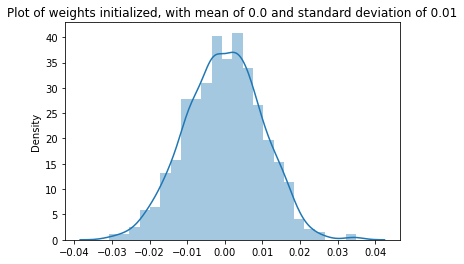

In [11]:
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

In [12]:
def initialize_bias(shape, name=None, dtype=float):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

C:\Users\NgocBaoNGUYEN\.conda\envs\defi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

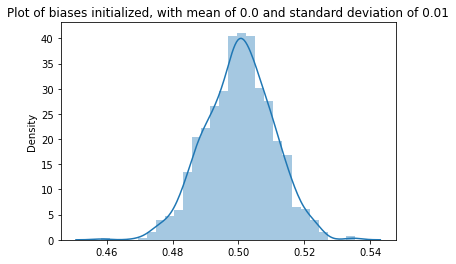

In [13]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [14]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [15]:
model = get_siamese_model((105, 105, 1))
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]        

### Optimizing function and loss function
The training was initially done using Stochastic gradient descent(as described in the paper) with a learning rate 0.0005(choosen randomly between 0.01 and 0.00001) initially, due to which the convergence of model was very slow, after 3000 iterations the validation decreased from .47 to .43, where when the training was done using Adam's algorithm to optimize the training process even though with a smaller learning rate of 0.00006, the decrease in the validation loss was much faster as compared to simple Stochastic Gradient Descent.



In [16]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Image Verification and Recognition



<img src="https://image.ibb.co/k3P0hJ/pixel_comparison.png" style="width:380px;height:150px;"></img>
<caption><center> <u> <font color='black'> **Figure 4**</font> </u></center></caption>
    
    





<img src="https://cdn-images-1.medium.com/max/800/1*wh1N-kogDMaZYS17lqyqeQ.jpeg"></img>
<caption><center> <u> <font color='black'> **Figure 5**</font> </u></center></caption>

## Dataset

<img src="https://cdn-images-1.medium.com/max/1600/1*fRd4Sc6cT0_KFm6IhB3Bqw.png"></img>
<caption><center> <u> <font color='black'> **Figure 6**</font> </u></center></caption>

To demonstrate one shot learning, [Omniglot dataset](https://github.com/brendenlake/omniglot) is used, Omniglot of Lake et al. is a MNIST-like scribbles dataset with 1623 characters with 20 examples each. The large number of classes (characters) with relatively few data per class (20), makes this an ideal data set for testing few-shot classification.

The figures below show few of the samples from the dataset.

In [17]:
def plot_images(path):
    """
        Plot all 20 samples of a particular character of a language
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = []
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        images_list.append(img)
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list.pop())

Arcadian language, 20 samples of the third character.


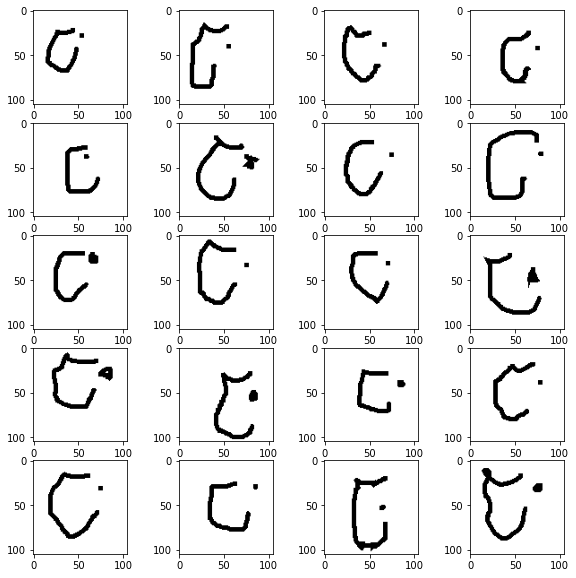

In [18]:
plot_images(os.path.join(data_path, 'images_background/Arcadian/character03/'))
print("Arcadian language, 20 samples of the third character.")

Korean language, 20 samples of the seventh character.


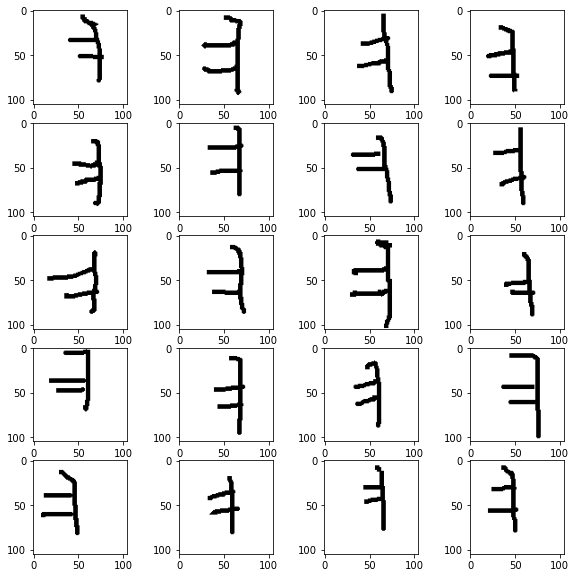

In [19]:
plot_images(os.path.join(data_path, 'images_background/Korean/character07/'))
print("Korean language, 20 samples of the seventh character.")

In [20]:
from load_data import *

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh
loa

In [21]:
with open(os.path.join(data_path, "train.pickle"), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(data_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(classes.keys()))
print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']
Validation alphabets:

['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


### Training pipeline

In [22]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))
    

loader = Siamese_Loader(data_path)

loading data from data/train.pickle
loading data from data/val.pickle


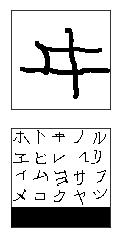

In [23]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)

<font color=red> This training process only take the best validation accuracy model throughout the whole training.
   
Observation: we did try training on both CPU and GPU. The estimated time on CPU was about 2 days while it was only several hours on GPU.

In [ ]:
weights_path = os.path.join(data_path, "model_weights.h5")
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path))
            model.save_weights(weights_path)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

t_end = time.time()
print('time: ',t_end-t_start)  

model.load_weights(weights_path)

Starting training process!
-------------------------------------


 ------------- 

Loss: 4.518354892730713

 ------------- 

Loss: 4.458484172821045

 ------------- 

Loss: 4.428064346313477

 ------------- 

Loss: 4.4070563316345215

 ------------- 

Loss: 4.401647090911865

 ------------- 

Loss: 4.379451274871826

 ------------- 

Loss: 4.403583526611328

 ------------- 

Loss: 4.333906173706055

 ------------- 

Loss: 4.3509135246276855

 ------------- 

Loss: 4.326872825622559
Time for 10 iterations: 21.46610116958618
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 27.6% 20 way one-shot learning accuracy 

Current best: 27.6, previous best: -1
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: 4.2686896324157715

 ------------- 

Loss: 4.279239654541016

 ------------- 

Loss: 4.252645969390869

 ------------- 

Loss: 4.226199626922607

 ------------- 

Loss: 4.186072826385498

 ------------- 

Loss: 4.2141923904418945

 -----

Got an average of 30.0% 20 way one-shot learning accuracy 

Current best: 30.0, previous best: 28.0
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: 2.7084646224975586

 ------------- 

Loss: 2.814663887023926

 ------------- 

Loss: 2.787018299102783

 ------------- 

Loss: 2.8715744018554688

 ------------- 

Loss: 2.8716111183166504

 ------------- 

Loss: 2.7102088928222656

 ------------- 

Loss: 2.7224395275115967

 ------------- 

Loss: 2.78483510017395

 ------------- 

Loss: 2.719228506088257

 ------------- 

Loss: 2.823281764984131
Time for 140 iterations: 144.83007097244263
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 26.4% 20 way one-shot learning accuracy 

iteration 140, training loss: 2.82,

 ------------- 

Loss: 2.7785403728485107

 ------------- 

Loss: 2.6276862621307373

 ------------- 

Loss: 2.6666743755340576

 ------------- 

Loss: 2.8327584266662598

 ------------- 

Loss: 2.8343799114227295

 --------


 ------------- 

Loss: 2.1654794216156006

 ------------- 

Loss: 2.3110556602478027

 ------------- 

Loss: 2.3521742820739746

 ------------- 

Loss: 2.192502021789551

 ------------- 

Loss: 2.128425121307373

 ------------- 

Loss: 2.1892945766448975

 ------------- 

Loss: 2.09375

 ------------- 

Loss: 2.377293109893799

 ------------- 

Loss: 2.1452579498291016

 ------------- 

Loss: 2.3311562538146973
Time for 270 iterations: 265.7050635814667
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 34.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 2.149116039276123

 ------------- 

Loss: 2.107774257659912

 ------------- 

Loss: 2.0819966793060303

 ------------- 

Loss: 2.2031846046447754

 ------------- 

Loss: 2.127336025238037

 ------------- 

Loss: 2.1648824214935303

 ------------- 

Loss: 2.2354679107666016

 ------------- 

Loss: 2.425276756286621

 ------------- 

Loss: 2.186884880065918

 ------------- 

Loss: 2.24541


 ------------- 

Loss: 1.738322138786316

 ------------- 

Loss: 1.9507648944854736

 ------------- 

Loss: 2.0514862537384033

 ------------- 

Loss: 1.7663850784301758

 ------------- 

Loss: 1.74579656124115

 ------------- 

Loss: 1.6546646356582642

 ------------- 

Loss: 1.845841884613037

 ------------- 

Loss: 1.6024994850158691
Time for 400 iterations: 387.64288806915283
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 42.4% 20 way one-shot learning accuracy 

Current best: 42.4, previous best: 37.6
Saving weights to: data/model_weights.h5 

iteration 400, training loss: 1.60,

 ------------- 

Loss: 1.6764614582061768

 ------------- 

Loss: 1.7469381093978882

 ------------- 

Loss: 1.8361923694610596

 ------------- 

Loss: 1.6609678268432617

 ------------- 

Loss: 1.7336082458496094

 ------------- 

Loss: 1.8372738361358643

 ------------- 

Loss: 1.7137129306793213

 ------------- 

Loss: 1.7927411794662476

 ------------- 

Loss: 1

Got an average of 43.2% 20 way one-shot learning accuracy 

iteration 520, training loss: 1.46,

 ------------- 

Loss: 1.4942102432250977

 ------------- 

Loss: 1.4548640251159668

 ------------- 

Loss: 1.5376399755477905

 ------------- 

Loss: 1.554134488105774

 ------------- 

Loss: 1.6025848388671875

 ------------- 

Loss: 1.5762296915054321

 ------------- 

Loss: 1.577439308166504

 ------------- 

Loss: 1.5177878141403198

 ------------- 

Loss: 1.5422669649124146

 ------------- 

Loss: 1.612460970878601
Time for 530 iterations: 510.28350925445557
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 45.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 1.512623906135559

 ------------- 

Loss: 1.5325374603271484

 ------------- 

Loss: 1.488433837890625

 ------------- 

Loss: 1.5712394714355469

 ------------- 

Loss: 1.4935524463653564

 ------------- 

Loss: 1.5737301111221313

 ------------- 

Loss: 1.4830126762390137

 ----

Got an average of 50.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 1.408976674079895

 ------------- 

Loss: 1.287980079650879

 ------------- 

Loss: 1.2891252040863037

 ------------- 

Loss: 1.330353856086731

 ------------- 

Loss: 1.2097793817520142

 ------------- 

Loss: 1.2384133338928223

 ------------- 

Loss: 1.3596827983856201

 ------------- 

Loss: 1.374074101448059

 ------------- 

Loss: 1.3656156063079834

 ------------- 

Loss: 1.4443165063858032
Time for 660 iterations: 632.1256914138794
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 54.0% 20 way one-shot learning accuracy 

iteration 660, training loss: 1.44,

 ------------- 

Loss: 1.3720821142196655

 ------------- 

Loss: 1.4279013872146606

 ------------- 

Loss: 1.2951714992523193

 ------------- 

Loss: 1.3288179636001587

 ------------- 

Loss: 1.3163100481033325

 ------------- 

Loss: 1.2566131353378296

 ------------- 

Loss: 1.373754620552063

 -----


 ------------- 

Loss: 1.255197286605835

 ------------- 

Loss: 1.187821865081787

 ------------- 

Loss: 1.0946723222732544

 ------------- 

Loss: 1.2099770307540894

 ------------- 

Loss: 1.1418062448501587

 ------------- 

Loss: 1.1503820419311523

 ------------- 

Loss: 1.148679256439209

 ------------- 

Loss: 1.1509767770767212

 ------------- 

Loss: 1.2326713800430298
Time for 790 iterations: 753.3624544143677
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 51.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 1.0583956241607666

 ------------- 

Loss: 1.122963547706604

 ------------- 

Loss: 1.1356477737426758

 ------------- 

Loss: 1.4127559661865234

 ------------- 

Loss: 1.2823007106781006

 ------------- 

Loss: 1.2181329727172852

 ------------- 

Loss: 1.1936192512512207

 ------------- 

Loss: 1.1319763660430908

 ------------- 

Loss: 1.153487205505371

 ------------- 

Loss: 1.0563100576400757
Time for 800 iter


 ------------- 

Loss: 1.134889841079712

 ------------- 

Loss: 1.1549087762832642

 ------------- 

Loss: 1.1739096641540527

 ------------- 

Loss: 1.0848417282104492

 ------------- 

Loss: 0.9659350514411926

 ------------- 

Loss: 1.0064482688903809

 ------------- 

Loss: 1.0054231882095337

 ------------- 

Loss: 1.1482712030410767
Time for 920 iterations: 875.0591766834259
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 53.2% 20 way one-shot learning accuracy 

iteration 920, training loss: 1.15,

 ------------- 

Loss: 0.9783873558044434

 ------------- 

Loss: 0.9709824919700623

 ------------- 

Loss: 0.9842257499694824

 ------------- 

Loss: 1.0920884609222412

 ------------- 

Loss: 1.1084846258163452

 ------------- 

Loss: 0.9969669580459595

 ------------- 

Loss: 1.0607622861862183

 ------------- 

Loss: 0.9813709259033203

 ------------- 

Loss: 1.0258915424346924

 ------------- 

Loss: 1.1565362215042114
Time for 930 iterati


 ------------- 

Loss: 0.9594302177429199

 ------------- 

Loss: 0.9154062867164612

 ------------- 

Loss: 1.0692461729049683

 ------------- 

Loss: 0.8815569281578064

 ------------- 

Loss: 1.0603126287460327

 ------------- 

Loss: 1.1269879341125488

 ------------- 

Loss: 0.9200838208198547

 ------------- 

Loss: 1.036662220954895
Time for 1050 iterations: 996.4679543972015
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 57.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 1.0613665580749512

 ------------- 

Loss: 0.918063223361969

 ------------- 

Loss: 1.0507161617279053

 ------------- 

Loss: 0.9765050411224365

 ------------- 

Loss: 1.0527030229568481

 ------------- 

Loss: 0.9140290021896362

 ------------- 

Loss: 1.1901159286499023

 ------------- 

Loss: 1.0517632961273193

 ------------- 

Loss: 1.003556489944458

 ------------- 

Loss: 1.0008468627929688
Time for 1060 iterations: 1005.7377443313599
Evaluating m


 ------------- 

Loss: 0.8828625679016113

 ------------- 

Loss: 0.9040426015853882

 ------------- 

Loss: 0.9427288770675659

 ------------- 

Loss: 0.9016610980033875

 ------------- 

Loss: 1.0424436330795288

 ------------- 

Loss: 0.993625283241272
Time for 1180 iterations: 1117.3115978240967
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 62.0% 20 way one-shot learning accuracy 

iteration 1180, training loss: 0.99,

 ------------- 

Loss: 1.012030839920044

 ------------- 

Loss: 0.812369704246521

 ------------- 

Loss: 1.0276188850402832

 ------------- 

Loss: 0.9197448492050171

 ------------- 

Loss: 0.829062819480896

 ------------- 

Loss: 1.01059889793396

 ------------- 

Loss: 1.073828935623169

 ------------- 

Loss: 0.8645260334014893

 ------------- 

Loss: 0.9126870632171631

 ------------- 

Loss: 0.9880729913711548
Time for 1190 iterations: 1126.564156293869
Evaluating model on 250 random 20 way one-shot learning tasks ...


 ------------- 

Loss: 0.9198704957962036

 ------------- 

Loss: 0.8680742383003235

 ------------- 

Loss: 0.8364146947860718

 ------------- 

Loss: 0.9530425071716309

 ------------- 

Loss: 0.849014163017273
Time for 1310 iterations: 1238.1936123371124
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 56.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.9055790901184082

 ------------- 

Loss: 0.7841046452522278

 ------------- 

Loss: 0.8685263991355896

 ------------- 

Loss: 0.85484778881073

 ------------- 

Loss: 0.93996661901474

 ------------- 

Loss: 0.7509849667549133

 ------------- 

Loss: 0.8565128445625305

 ------------- 

Loss: 0.8749578595161438

 ------------- 

Loss: 0.8830520510673523

 ------------- 

Loss: 0.774109959602356
Time for 1320 iterations: 1247.44633436203
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 63.6% 20 way one-shot learning accuracy 

iteration 1320, t


 ------------- 

Loss: 0.800378680229187

 ------------- 

Loss: 0.7937254309654236

 ------------- 

Loss: 0.9737964868545532
Time for 1440 iterations: 1359.0104763507843
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 65.6% 20 way one-shot learning accuracy 

iteration 1440, training loss: 0.97,

 ------------- 

Loss: 0.7445963025093079

 ------------- 

Loss: 0.6953204870223999

 ------------- 

Loss: 0.9043289422988892

 ------------- 

Loss: 0.8090031147003174

 ------------- 

Loss: 0.8711279034614563

 ------------- 

Loss: 0.8497657179832458

 ------------- 

Loss: 0.8554272651672363

 ------------- 

Loss: 0.7448889017105103

 ------------- 

Loss: 0.8473036289215088

 ------------- 

Loss: 0.789212167263031
Time for 1450 iterations: 1368.261973619461
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 63.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.956411600112915

 ------------- 

L


 ------------- 

Loss: 0.7698056101799011

 ------------- 

Loss: 0.7836716175079346

 ------------- 

Loss: 0.7829567193984985

 ------------- 

Loss: 0.7217867970466614
Time for 1570 iterations: 1480.2598860263824
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 56.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.8457207679748535

 ------------- 

Loss: 0.826919674873352

 ------------- 

Loss: 0.7351305484771729

 ------------- 

Loss: 0.775624692440033

 ------------- 

Loss: 0.9170973300933838

 ------------- 

Loss: 0.7427957653999329

 ------------- 

Loss: 0.7572322487831116

 ------------- 

Loss: 0.9814381003379822

 ------------- 

Loss: 0.8613916039466858

 ------------- 

Loss: 0.8246330618858337
Time for 1580 iterations: 1489.5244789123535
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 60.8% 20 way one-shot learning accuracy 

iteration 1580, training loss: 0.82,

 ------------- 



 ------------- 

Loss: 0.7875271439552307

 ------------- 

Loss: 0.8233782052993774
Time for 1700 iterations: 1600.9904255867004
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 62.8% 20 way one-shot learning accuracy 

iteration 1700, training loss: 0.82,

 ------------- 

Loss: 0.7093296051025391

 ------------- 

Loss: 0.6054256558418274

 ------------- 

Loss: 0.709473729133606

 ------------- 

Loss: 0.6374561190605164

 ------------- 

Loss: 0.8042397499084473

 ------------- 

Loss: 0.7171432375907898

 ------------- 

Loss: 0.7255947589874268

 ------------- 

Loss: 0.7318068146705627

 ------------- 

Loss: 0.6716674566268921

 ------------- 

Loss: 0.7368432283401489
Time for 1710 iterations: 1610.2475898265839
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 63.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.661669909954071

 ------------- 

Loss: 0.6533117294311523

 ------------- 


Got an average of 59.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.6530770659446716

 ------------- 

Loss: 0.6874760389328003

 ------------- 

Loss: 0.7926042079925537

 ------------- 

Loss: 0.6573930382728577

 ------------- 

Loss: 0.7249666452407837

 ------------- 

Loss: 0.6681442856788635

 ------------- 

Loss: 0.5621474385261536

 ------------- 

Loss: 0.7052579522132874

 ------------- 

Loss: 0.5581352710723877

 ------------- 

Loss: 0.7609739303588867
Time for 1840 iterations: 1731.7186992168427
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 56.8% 20 way one-shot learning accuracy 

iteration 1840, training loss: 0.76,

 ------------- 

Loss: 0.8535511493682861

 ------------- 

Loss: 0.6342365741729736

 ------------- 

Loss: 0.6217643022537231

 ------------- 

Loss: 0.6077461242675781

 ------------- 

Loss: 0.7659819722175598

 ------------- 

Loss: 0.5565880537033081

 ------------- 

Loss: 0.6993821263313293


 ------------- 

Loss: 0.6690633296966553

 ------------- 

Loss: 0.7105495929718018

 ------------- 

Loss: 0.5709221363067627

 ------------- 

Loss: 0.6131616830825806

 ------------- 

Loss: 0.9629611968994141

 ------------- 

Loss: 0.5750910043716431

 ------------- 

Loss: 0.6111111640930176

 ------------- 

Loss: 0.5321746468544006
Time for 1970 iterations: 1858.6381950378418
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.6870878338813782

 ------------- 

Loss: 0.6188278198242188

 ------------- 

Loss: 0.5792263746261597

 ------------- 

Loss: 0.8162422180175781

 ------------- 

Loss: 0.6626161336898804

 ------------- 

Loss: 0.5621465444564819

 ------------- 

Loss: 0.5217880606651306

 ------------- 

Loss: 0.7192279100418091

 ------------- 

Loss: 0.6145600080490112

 ------------- 

Loss: 0.6487590074539185
Time for 1980 iterations: 1868.3610351085663
Evaluati


 ------------- 

Loss: 0.6295374035835266

 ------------- 

Loss: 0.5704929232597351

 ------------- 

Loss: 0.5897911787033081

 ------------- 

Loss: 0.6471617817878723
Time for 2100 iterations: 1984.553682565689
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.0% 20 way one-shot learning accuracy 

iteration 2100, training loss: 0.65,

 ------------- 

Loss: 0.6775436401367188

 ------------- 

Loss: 0.6010575890541077

 ------------- 

Loss: 0.5691460371017456

 ------------- 

Loss: 0.5432240962982178

 ------------- 

Loss: 0.5914857387542725

 ------------- 

Loss: 0.5950623750686646

 ------------- 

Loss: 0.7208471298217773

 ------------- 

Loss: 0.607660710811615

 ------------- 

Loss: 0.5574048161506653

 ------------- 

Loss: 0.7946764230728149
Time for 2110 iterations: 1994.0551879405975
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 


 ------------- 



 ------------- 

Loss: 0.5249044299125671
Time for 2230 iterations: 2108.520818710327
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 62.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.49411651492118835

 ------------- 

Loss: 0.6814638376235962

 ------------- 

Loss: 0.5143235325813293

 ------------- 

Loss: 0.5891878604888916

 ------------- 

Loss: 0.5077097415924072

 ------------- 

Loss: 0.6337867379188538

 ------------- 

Loss: 0.5696887969970703

 ------------- 

Loss: 0.7760280966758728

 ------------- 

Loss: 0.5040284395217896

 ------------- 

Loss: 0.6355960369110107
Time for 2240 iterations: 2118.023663520813
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.2% 20 way one-shot learning accuracy 

iteration 2240, training loss: 0.64,

 ------------- 

Loss: 0.9105149507522583

 ------------- 

Loss: 0.5194138288497925

 ------------- 

Loss: 0.5547259449958801

 ------------- 

Got an average of 70.0% 20 way one-shot learning accuracy 

iteration 2360, training loss: 0.46,

 ------------- 

Loss: 0.6130669116973877

 ------------- 

Loss: 0.5126949548721313

 ------------- 

Loss: 0.5945963859558105

 ------------- 

Loss: 0.5026014447212219

 ------------- 

Loss: 0.4471551179885864

 ------------- 

Loss: 0.5408123731613159

 ------------- 

Loss: 0.6085544228553772

 ------------- 

Loss: 0.5221476554870605

 ------------- 

Loss: 0.6023338437080383

 ------------- 

Loss: 0.4865701496601105
Time for 2370 iterations: 2241.5657439231873
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 62.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.5407778024673462

 ------------- 

Loss: 0.5358926057815552

 ------------- 

Loss: 0.5959901809692383

 ------------- 

Loss: 0.6816607117652893

 ------------- 

Loss: 0.5634254217147827

 ------------- 

Loss: 0.8215076923370361

 ------------- 

Loss: 0.5262326002120972


 ------------- 

Loss: 0.7730572819709778

 ------------- 

Loss: 0.5381287932395935

 ------------- 

Loss: 0.46506404876708984

 ------------- 

Loss: 0.5181981325149536

 ------------- 

Loss: 0.597760796546936

 ------------- 

Loss: 0.5071005821228027

 ------------- 

Loss: 0.6003923416137695

 ------------- 

Loss: 0.5089824795722961
Time for 2500 iterations: 2365.0806210041046
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

Current best: 79.2, previous best: 73.6
Saving weights to: data/model_weights.h5 

iteration 2500, training loss: 0.51,

 ------------- 

Loss: 0.5229448080062866

 ------------- 

Loss: 0.5192199349403381

 ------------- 

Loss: 0.5204245448112488

 ------------- 

Loss: 0.49980559945106506

 ------------- 

Loss: 0.5847105979919434

 ------------- 

Loss: 0.6173248291015625

 ------------- 

Loss: 0.5423321723937988

 ------------- 

Loss: 0.4857323169708252

 ------------- 




 ------------- 

Loss: 0.43909507989883423

 ------------- 

Loss: 0.4882475733757019

 ------------- 

Loss: 0.7362279295921326

 ------------- 

Loss: 0.5547261238098145

 ------------- 

Loss: 0.4886676073074341

 ------------- 

Loss: 0.4753250479698181

 ------------- 

Loss: 0.5396171808242798
Time for 2630 iterations: 2491.008058309555
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 60.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.6518436074256897

 ------------- 

Loss: 0.5027477741241455

 ------------- 

Loss: 0.5476612448692322

 ------------- 

Loss: 0.5290257930755615

 ------------- 

Loss: 0.445157915353775

 ------------- 

Loss: 0.5537186861038208

 ------------- 

Loss: 0.44622066617012024

 ------------- 

Loss: 0.5051769614219666

 ------------- 

Loss: 0.4862675666809082

 ------------- 

Loss: 0.6542060375213623
Time for 2640 iterations: 2500.5226740837097
Evaluating model on 250 random 20 way one-shot lear


 ------------- 

Loss: 0.5431793928146362

 ------------- 

Loss: 0.45647773146629333

 ------------- 

Loss: 0.518389105796814

 ------------- 

Loss: 0.4696310758590698
Time for 2760 iterations: 2613.2728605270386
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.0% 20 way one-shot learning accuracy 

iteration 2760, training loss: 0.47,

 ------------- 

Loss: 0.4092821478843689

 ------------- 

Loss: 0.524336040019989

 ------------- 

Loss: 0.66926509141922

 ------------- 

Loss: 0.530728816986084

 ------------- 

Loss: 0.4800903797149658

 ------------- 

Loss: 0.4811476767063141

 ------------- 

Loss: 0.4150260388851166

 ------------- 

Loss: 0.41687723994255066

 ------------- 

Loss: 0.5269331336021423

 ------------- 

Loss: 0.5113759636878967
Time for 2770 iterations: 2622.5288450717926
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 65.6% 20 way one-shot learning accuracy 


 ------------- 




 ------------- 

Loss: 0.5428664684295654

 ------------- 

Loss: 0.5838147401809692
Time for 2890 iterations: 2733.4026293754578
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.4514979124069214

 ------------- 

Loss: 0.47794109582901

 ------------- 

Loss: 0.6026567220687866

 ------------- 

Loss: 0.5418562889099121

 ------------- 

Loss: 0.48336002230644226

 ------------- 

Loss: 0.5014470815658569

 ------------- 

Loss: 0.4434496760368347

 ------------- 

Loss: 0.43654173612594604

 ------------- 

Loss: 0.45622265338897705

 ------------- 

Loss: 0.49357569217681885
Time for 2900 iterations: 2742.6551327705383
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 2900, training loss: 0.49,

 ------------- 

Loss: 0.5917725563049316

 ------------- 

Loss: 0.44219958782196045

 ----------

Got an average of 70.4% 20 way one-shot learning accuracy 

iteration 3020, training loss: 0.38,

 ------------- 

Loss: 0.5943590402603149

 ------------- 

Loss: 0.38647347688674927

 ------------- 

Loss: 0.3799973726272583

 ------------- 

Loss: 0.46483147144317627

 ------------- 

Loss: 0.49924784898757935

 ------------- 

Loss: 0.4257071018218994

 ------------- 

Loss: 0.4898875951766968

 ------------- 

Loss: 0.4761386513710022

 ------------- 

Loss: 0.3737136125564575

 ------------- 

Loss: 0.5675240755081177
Time for 3030 iterations: 2862.7262732982635
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.44109565019607544

 ------------- 

Loss: 0.3813245892524719

 ------------- 

Loss: 0.4269942045211792

 ------------- 

Loss: 0.5800700187683105

 ------------- 

Loss: 0.4727632999420166

 ------------- 

Loss: 0.477215439081192

 ------------- 

Loss: 0.4080421328544


 ------------- 

Loss: 0.44143301248550415

 ------------- 

Loss: 0.37271517515182495

 ------------- 

Loss: 0.42869654297828674

 ------------- 

Loss: 0.5144407153129578

 ------------- 

Loss: 0.3414088785648346

 ------------- 

Loss: 0.5617294311523438

 ------------- 

Loss: 0.4542091488838196

 ------------- 

Loss: 0.35582223534584045

 ------------- 

Loss: 0.5054430365562439
Time for 3160 iterations: 2982.8198807239532
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.2% 20 way one-shot learning accuracy 

iteration 3160, training loss: 0.51,

 ------------- 

Loss: 0.4944339394569397

 ------------- 

Loss: 0.5648797750473022

 ------------- 

Loss: 0.3554161787033081

 ------------- 

Loss: 0.40471142530441284

 ------------- 

Loss: 0.4427546560764313

 ------------- 

Loss: 0.46864116191864014

 ------------- 

Loss: 0.5377112627029419

 ------------- 

Loss: 0.4920521378517151

 ------------- 

Loss: 0.36525893211364746

 -------


 ------------- 

Loss: 0.4090660810470581

 ------------- 

Loss: 0.4173413813114166

 ------------- 

Loss: 0.37839898467063904

 ------------- 

Loss: 0.42149579524993896

 ------------- 

Loss: 0.3971036672592163

 ------------- 

Loss: 0.3653400242328644

 ------------- 

Loss: 0.4449406564235687
Time for 3290 iterations: 3102.892987012863
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.6524397134780884

 ------------- 

Loss: 0.43343386054039

 ------------- 

Loss: 0.37580400705337524

 ------------- 

Loss: 0.38486748933792114

 ------------- 

Loss: 0.3950127065181732

 ------------- 

Loss: 0.43244457244873047

 ------------- 

Loss: 0.45405346155166626

 ------------- 

Loss: 0.39476388692855835

 ------------- 

Loss: 0.48581042885780334

 ------------- 

Loss: 0.40563565492630005
Time for 3300 iterations: 3112.1207427978516
Evaluating model on 250 random 20 way one-sho


 ------------- 

Loss: 0.595255970954895

 ------------- 

Loss: 0.4144335389137268

 ------------- 

Loss: 0.37233856320381165

 ------------- 

Loss: 0.3523254096508026
Time for 3420 iterations: 3222.9573776721954
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

Current best: 80.0, previous best: 79.2
Saving weights to: data/model_weights.h5 

iteration 3420, training loss: 0.35,

 ------------- 

Loss: 0.5133398771286011

 ------------- 

Loss: 0.38863420486450195

 ------------- 

Loss: 0.5743170976638794

 ------------- 

Loss: 0.4273836612701416

 ------------- 

Loss: 0.3737356960773468

 ------------- 

Loss: 0.3633296489715576

 ------------- 

Loss: 0.3398347496986389

 ------------- 

Loss: 0.5724667906761169

 ------------- 

Loss: 0.6643321514129639

 ------------- 

Loss: 0.41773512959480286
Time for 3430 iterations: 3232.667670726776
Evaluating model on 250 random 20 way one-shot learning tas


 ------------- 

Loss: 0.3383409380912781

 ------------- 

Loss: 0.5235545635223389

 ------------- 

Loss: 0.35246098041534424

 ------------- 

Loss: 0.3838491141796112
Time for 3550 iterations: 3343.5611221790314
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.5061988234519958

 ------------- 

Loss: 0.4148433804512024

 ------------- 

Loss: 0.540682852268219

 ------------- 

Loss: 0.4556388556957245

 ------------- 

Loss: 0.42973214387893677

 ------------- 

Loss: 0.40173882246017456

 ------------- 

Loss: 0.49350911378860474

 ------------- 

Loss: 0.4501417875289917

 ------------- 

Loss: 0.4145835041999817

 ------------- 

Loss: 0.35191628336906433
Time for 3560 iterations: 3352.806005001068
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 

iteration 3560, training loss: 0.35,

 ----------


 ------------- 

Loss: 0.5789391994476318
Time for 3680 iterations: 3463.6471016407013
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.8% 20 way one-shot learning accuracy 

iteration 3680, training loss: 0.58,

 ------------- 

Loss: 0.48519593477249146

 ------------- 

Loss: 0.36187437176704407

 ------------- 

Loss: 0.3828757703304291

 ------------- 

Loss: 0.3436904847621918

 ------------- 

Loss: 0.5098730325698853

 ------------- 

Loss: 0.31997010111808777

 ------------- 

Loss: 0.37305790185928345

 ------------- 

Loss: 0.5113354921340942

 ------------- 

Loss: 0.3749198317527771

 ------------- 

Loss: 0.37711337208747864
Time for 3690 iterations: 3472.8769726753235
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.37207481265068054

 ------------- 

Loss: 0.48070669174194336

 ------------- 

Loss: 0.3522268533706665

 ------

Got an average of 76.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3336315453052521

 ------------- 

Loss: 0.31470465660095215

 ------------- 

Loss: 0.3414769470691681

 ------------- 

Loss: 0.5822023153305054

 ------------- 

Loss: 0.6812254786491394

 ------------- 

Loss: 0.3280036747455597

 ------------- 

Loss: 0.5824865102767944

 ------------- 

Loss: 0.4825999140739441

 ------------- 

Loss: 0.32938480377197266

 ------------- 

Loss: 0.30325037240982056
Time for 3820 iterations: 3592.9960691928864
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.4% 20 way one-shot learning accuracy 

iteration 3820, training loss: 0.30,

 ------------- 

Loss: 0.46399298310279846

 ------------- 

Loss: 0.4040939211845398

 ------------- 

Loss: 0.39014244079589844

 ------------- 

Loss: 0.31586727499961853

 ------------- 

Loss: 0.405867338180542

 ------------- 

Loss: 0.4178837239742279

 ------------- 

Loss: 0.38143098354


 ------------- 

Loss: 0.439389169216156

 ------------- 

Loss: 0.33827072381973267

 ------------- 

Loss: 0.48155662417411804

 ------------- 

Loss: 0.3198457956314087

 ------------- 

Loss: 0.33534669876098633

 ------------- 

Loss: 0.6546741724014282

 ------------- 

Loss: 0.34142640233039856

 ------------- 

Loss: 0.32990819215774536

 ------------- 

Loss: 0.3082268238067627
Time for 3950 iterations: 3713.0505650043488
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.39020395278930664

 ------------- 

Loss: 0.43966227769851685

 ------------- 

Loss: 0.37877899408340454

 ------------- 

Loss: 0.2840783894062042

 ------------- 

Loss: 0.3416597247123718

 ------------- 

Loss: 0.41411542892456055

 ------------- 

Loss: 0.5639441013336182

 ------------- 

Loss: 0.3258861005306244

 ------------- 

Loss: 0.4609280824661255

 ------------- 

Loss: 0.42820629477500916
T


 ------------- 

Loss: 0.33700689673423767

 ------------- 

Loss: 0.3537432551383972

 ------------- 

Loss: 0.35680219531059265

 ------------- 

Loss: 0.29669904708862305

 ------------- 

Loss: 0.37585633993148804

 ------------- 

Loss: 0.43807196617126465
Time for 4080 iterations: 3833.3015303611755
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 

iteration 4080, training loss: 0.44,

 ------------- 

Loss: 0.4179389476776123

 ------------- 

Loss: 0.3496900796890259

 ------------- 

Loss: 0.39938968420028687

 ------------- 

Loss: 0.41040176153182983

 ------------- 

Loss: 0.339680552482605

 ------------- 

Loss: 0.39665713906288147

 ------------- 

Loss: 0.3736908435821533

 ------------- 

Loss: 0.3812796175479889

 ------------- 

Loss: 0.3670291304588318

 ------------- 

Loss: 0.5639510750770569
Time for 4090 iterations: 3842.545703649521
Evaluating model on 250 random 20 way one-shot lear


 ------------- 

Loss: 0.3317660093307495

 ------------- 

Loss: 0.29175901412963867

 ------------- 

Loss: 0.4483552575111389

 ------------- 

Loss: 0.37606996297836304

 ------------- 

Loss: 0.33944565057754517
Time for 4210 iterations: 3953.315933704376
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3144296705722809

 ------------- 

Loss: 0.30787408351898193

 ------------- 

Loss: 0.3266444206237793

 ------------- 

Loss: 0.40037471055984497

 ------------- 

Loss: 0.3453119695186615

 ------------- 

Loss: 0.4150947332382202

 ------------- 

Loss: 0.3249991834163666

 ------------- 

Loss: 0.27206993103027344

 ------------- 

Loss: 0.34383851289749146

 ------------- 

Loss: 0.28581464290618896
Time for 4220 iterations: 3962.544158220291
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 

ite


 ------------- 

Loss: 0.2954571843147278

 ------------- 

Loss: 0.33431100845336914
Time for 4340 iterations: 4073.3013994693756
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

Current best: 80.8, previous best: 80.0
Saving weights to: data/model_weights.h5 

iteration 4340, training loss: 0.33,

 ------------- 

Loss: 0.3281395435333252

 ------------- 

Loss: 0.3744771182537079

 ------------- 

Loss: 0.3295269012451172

 ------------- 

Loss: 0.35488319396972656

 ------------- 

Loss: 0.3108347952365875

 ------------- 

Loss: 0.4055333137512207

 ------------- 

Loss: 0.34664660692214966

 ------------- 

Loss: 0.3543452322483063

 ------------- 

Loss: 0.36298149824142456

 ------------- 

Loss: 0.2969423830509186
Time for 4350 iterations: 4082.9868030548096
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 


 ------------


 ------------- 

Loss: 0.38999760150909424

 ------------- 

Loss: 0.3788856267929077
Time for 4470 iterations: 4193.762809514999
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3454330861568451

 ------------- 

Loss: 0.3412284255027771

 ------------- 

Loss: 0.27522486448287964

 ------------- 

Loss: 0.35896003246307373

 ------------- 

Loss: 0.3221113979816437

 ------------- 

Loss: 0.3690696656703949

 ------------- 

Loss: 0.45235180854797363

 ------------- 

Loss: 0.3255489766597748

 ------------- 

Loss: 0.3351162374019623

 ------------- 

Loss: 0.5597511529922485
Time for 4480 iterations: 4203.000960111618
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 4480, training loss: 0.56,

 ------------- 

Loss: 0.45966219902038574

 ------------- 

Loss: 0.34286758303642273

 ---------

Got an average of 72.4% 20 way one-shot learning accuracy 

iteration 4600, training loss: 0.29,

 ------------- 

Loss: 0.34905701875686646

 ------------- 

Loss: 0.40279126167297363

 ------------- 

Loss: 0.3203229010105133

 ------------- 

Loss: 0.2967301905155182

 ------------- 

Loss: 0.3054134249687195

 ------------- 

Loss: 0.3530424237251282

 ------------- 

Loss: 0.38158559799194336

 ------------- 

Loss: 0.27646273374557495

 ------------- 

Loss: 0.6378961205482483

 ------------- 

Loss: 0.320606529712677
Time for 4610 iterations: 4322.9834768772125
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.35892224311828613

 ------------- 

Loss: 0.31661832332611084

 ------------- 

Loss: 0.34713733196258545

 ------------- 

Loss: 0.2739872932434082

 ------------- 

Loss: 0.3271017074584961

 ------------- 

Loss: 0.3462233543395996

 ------------- 

Loss: 0.4155655801


 ------------- 

Loss: 0.47278332710266113

 ------------- 

Loss: 0.361733615398407

 ------------- 

Loss: 0.42476290464401245

 ------------- 

Loss: 0.5750848054885864

 ------------- 

Loss: 0.33342015743255615

 ------------- 

Loss: 0.2678523659706116

 ------------- 

Loss: 0.3101743757724762

 ------------- 

Loss: 0.3406268358230591

 ------------- 

Loss: 0.31828737258911133
Time for 4740 iterations: 4443.3358545303345
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

iteration 4740, training loss: 0.32,

 ------------- 

Loss: 0.42696622014045715

 ------------- 

Loss: 0.46763813495635986

 ------------- 

Loss: 0.2888503074645996

 ------------- 

Loss: 0.3543807864189148

 ------------- 

Loss: 0.26776009798049927

 ------------- 

Loss: 0.29423463344573975

 ------------- 

Loss: 0.25568097829818726

 ------------- 

Loss: 0.30038538575172424

 ------------- 

Loss: 0.4888918995857239

 -----


 ------------- 

Loss: 0.39246731996536255

 ------------- 

Loss: 0.47746551036834717

 ------------- 

Loss: 0.392269104719162

 ------------- 

Loss: 0.4795376658439636

 ------------- 

Loss: 0.2501339614391327

 ------------- 

Loss: 0.3063373267650604

 ------------- 

Loss: 0.35054975748062134
Time for 4870 iterations: 4563.367056131363
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.402774453163147

 ------------- 

Loss: 0.30393022298812866

 ------------- 

Loss: 0.32370245456695557

 ------------- 

Loss: 0.3252759575843811

 ------------- 

Loss: 0.2621570825576782

 ------------- 

Loss: 0.3609864115715027

 ------------- 

Loss: 0.2659859359264374

 ------------- 

Loss: 0.2922745645046234

 ------------- 

Loss: 0.32792186737060547

 ------------- 

Loss: 0.25114861130714417
Time for 4880 iterations: 4572.595167636871
Evaluating model on 250 random 20 way one-shot l


 ------------- 

Loss: 0.3118946850299835

 ------------- 

Loss: 0.26909708976745605

 ------------- 

Loss: 0.3529245853424072

 ------------- 

Loss: 0.32619553804397583
Time for 5000 iterations: 4683.33672952652
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 

iteration 5000, training loss: 0.33,

 ------------- 

Loss: 0.4490760266780853

 ------------- 

Loss: 0.27255547046661377

 ------------- 

Loss: 0.3138306438922882

 ------------- 

Loss: 0.41320061683654785

 ------------- 

Loss: 0.362038791179657

 ------------- 

Loss: 0.3609403371810913

 ------------- 

Loss: 0.3541111350059509

 ------------- 

Loss: 0.28599703311920166

 ------------- 

Loss: 0.27892452478408813

 ------------- 

Loss: 0.35104042291641235
Time for 5010 iterations: 4692.5602288246155
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 


 ---------


 ------------- 

Loss: 0.2916232943534851

 ------------- 

Loss: 0.3608816862106323
Time for 5130 iterations: 4803.318306207657
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3459407687187195

 ------------- 

Loss: 0.5070652961730957

 ------------- 

Loss: 0.3059339225292206

 ------------- 

Loss: 0.3741326630115509

 ------------- 

Loss: 0.33623209595680237

 ------------- 

Loss: 0.47008800506591797

 ------------- 

Loss: 0.3120422959327698

 ------------- 

Loss: 0.2591990828514099

 ------------- 

Loss: 0.46267375349998474

 ------------- 

Loss: 0.3064329922199249
Time for 5140 iterations: 4812.538437604904
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 5140, training loss: 0.31,

 ------------- 

Loss: 0.3362228572368622

 ------------- 

Loss: 0.39756834506988525

 -----------

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 5260, training loss: 0.27,

 ------------- 

Loss: 0.2857600450515747

 ------------- 

Loss: 0.32985353469848633

 ------------- 

Loss: 0.2750450074672699

 ------------- 

Loss: 0.3181966543197632

 ------------- 

Loss: 0.2956196367740631

 ------------- 

Loss: 0.2941038906574249

 ------------- 

Loss: 0.39703941345214844

 ------------- 

Loss: 0.284050852060318

 ------------- 

Loss: 0.2840714156627655

 ------------- 

Loss: 0.32715409994125366
Time for 5270 iterations: 4932.567841529846
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.32848331332206726

 ------------- 

Loss: 0.3679471015930176

 ------------- 

Loss: 0.47015005350112915

 ------------- 

Loss: 0.2957345247268677

 ------------- 

Loss: 0.47043153643608093

 ------------- 

Loss: 0.32609066367149353

 ------------- 

Loss: 0.24547804892


 ------------- 

Loss: 0.2932246923446655

 ------------- 

Loss: 0.3892674446105957

 ------------- 

Loss: 0.3446255922317505

 ------------- 

Loss: 0.29729002714157104

 ------------- 

Loss: 0.2395268976688385

 ------------- 

Loss: 0.36641860008239746

 ------------- 

Loss: 0.3406398892402649

 ------------- 

Loss: 0.26707711815834045

 ------------- 

Loss: 0.28884756565093994

 ------------- 

Loss: 0.34297192096710205
Time for 5400 iterations: 5052.562528133392
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 5400, training loss: 0.34,

 ------------- 

Loss: 0.24497079849243164

 ------------- 

Loss: 0.31511175632476807

 ------------- 

Loss: 0.28851237893104553

 ------------- 

Loss: 0.29320693016052246

 ------------- 

Loss: 0.2778782248497009

 ------------- 

Loss: 0.34056514501571655

 ------------- 

Loss: 0.26956436038017273

 ------------- 

Loss: 0.32664334774017334

 ---


 ------------- 

Loss: 0.3396386206150055

 ------------- 

Loss: 0.2829110324382782

 ------------- 

Loss: 0.2385597676038742

 ------------- 

Loss: 0.4046032428741455

 ------------- 

Loss: 0.25093281269073486

 ------------- 

Loss: 0.3484082520008087

 ------------- 

Loss: 0.31579166650772095

 ------------- 

Loss: 0.3435906171798706
Time for 5530 iterations: 5172.545180559158
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3152103126049042

 ------------- 

Loss: 0.3528085947036743

 ------------- 

Loss: 0.3544820547103882

 ------------- 

Loss: 0.3895071744918823

 ------------- 

Loss: 0.25436827540397644

 ------------- 

Loss: 0.3614388704299927

 ------------- 

Loss: 0.3639681935310364

 ------------- 

Loss: 0.3611469268798828

 ------------- 

Loss: 0.27964091300964355

 ------------- 

Loss: 0.44494009017944336
Time for 5540 iterations: 5181.7810871601105
Eval


 ------------- 

Loss: 0.25328701734542847

 ------------- 

Loss: 0.3490533232688904

 ------------- 

Loss: 0.30014127492904663

 ------------- 

Loss: 0.2797081172466278

 ------------- 

Loss: 0.25462308526039124
Time for 5660 iterations: 5292.5682854652405
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 

iteration 5660, training loss: 0.25,

 ------------- 

Loss: 0.21764637529850006

 ------------- 

Loss: 0.3487487733364105

 ------------- 

Loss: 0.33651241660118103

 ------------- 

Loss: 0.4211825132369995

 ------------- 

Loss: 0.2529688775539398

 ------------- 

Loss: 0.30740103125572205

 ------------- 

Loss: 0.27028408646583557

 ------------- 

Loss: 0.4662569761276245

 ------------- 

Loss: 0.3063395619392395

 ------------- 

Loss: 0.3516717553138733
Time for 5670 iterations: 5301.802753686905
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20


 ------------- 

Loss: 0.4791868031024933

 ------------- 

Loss: 0.3743709921836853

 ------------- 

Loss: 0.4125557839870453

 ------------- 

Loss: 0.3486504554748535

 ------------- 

Loss: 0.4121096432209015
Time for 5790 iterations: 5413.064449548721
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.4522119462490082

 ------------- 

Loss: 0.3379267752170563

 ------------- 

Loss: 0.25567132234573364

 ------------- 

Loss: 0.3630629777908325

 ------------- 

Loss: 0.41250720620155334

 ------------- 

Loss: 0.2477271556854248

 ------------- 

Loss: 0.3375500440597534

 ------------- 

Loss: 0.47968369722366333

 ------------- 

Loss: 0.4448680877685547

 ------------- 

Loss: 0.31964075565338135
Time for 5800 iterations: 5422.29244184494
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.4% 20 way one-shot learning accuracy 

iteratio


 ------------- 

Loss: 0.3379862904548645

 ------------- 

Loss: 0.3300950825214386
Time for 5920 iterations: 5533.02055978775
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.8% 20 way one-shot learning accuracy 

iteration 5920, training loss: 0.33,

 ------------- 

Loss: 0.26907336711883545

 ------------- 

Loss: 0.3086816072463989

 ------------- 

Loss: 0.2277938574552536

 ------------- 

Loss: 0.34193509817123413

 ------------- 

Loss: 0.3080955743789673

 ------------- 

Loss: 0.23160822689533234

 ------------- 

Loss: 0.2999332547187805

 ------------- 

Loss: 0.353180468082428

 ------------- 

Loss: 0.39111146330833435

 ------------- 

Loss: 0.23804889619350433
Time for 5930 iterations: 5542.247559070587
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.282049298286438

 ------------- 

Loss: 0.25646063685417175

 ------------

Got an average of 73.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.35977548360824585

 ------------- 

Loss: 0.26142096519470215

 ------------- 

Loss: 0.22682002186775208

 ------------- 

Loss: 0.33071091771125793

 ------------- 

Loss: 0.286832332611084

 ------------- 

Loss: 0.3138865828514099

 ------------- 

Loss: 0.21021820604801178

 ------------- 

Loss: 0.212905615568161

 ------------- 

Loss: 0.29258233308792114

 ------------- 

Loss: 0.30386883020401
Time for 6060 iterations: 5662.256184577942
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.0% 20 way one-shot learning accuracy 

iteration 6060, training loss: 0.30,

 ------------- 

Loss: 0.28837084770202637

 ------------- 

Loss: 0.3877089023590088

 ------------- 

Loss: 0.23994946479797363

 ------------- 

Loss: 0.3130823075771332

 ------------- 

Loss: 0.3747917413711548

 ------------- 

Loss: 0.23042753338813782

 ------------- 

Loss: 0.242140531539


 ------------- 

Loss: 0.270650714635849

 ------------- 

Loss: 0.24020129442214966

 ------------- 

Loss: 0.21098941564559937

 ------------- 

Loss: 0.25425848364830017

 ------------- 

Loss: 0.3227214813232422

 ------------- 

Loss: 0.3746967315673828

 ------------- 

Loss: 0.37462499737739563

 ------------- 

Loss: 0.23678934574127197

 ------------- 

Loss: 0.2452794313430786

 ------------- 

Loss: 0.2686198651790619
Time for 6190 iterations: 5782.2245943546295
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2611325979232788

 ------------- 

Loss: 0.26362448930740356

 ------------- 

Loss: 0.23729990422725677

 ------------- 

Loss: 0.23142662644386292

 ------------- 

Loss: 0.2960425913333893

 ------------- 

Loss: 0.34864330291748047

 ------------- 

Loss: 0.23271197080612183

 ------------- 

Loss: 0.24281011521816254

 ------------- 

Loss: 0.2557876706123352



 ------------- 

Loss: 0.2680434286594391

 ------------- 

Loss: 0.3926333785057068

 ------------- 

Loss: 0.2767806947231293

 ------------- 

Loss: 0.34547269344329834

 ------------- 

Loss: 0.2690562605857849

 ------------- 

Loss: 0.21771252155303955

 ------------- 

Loss: 0.3364992141723633

 ------------- 

Loss: 0.3774716854095459
Time for 6320 iterations: 5902.242032766342
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.6% 20 way one-shot learning accuracy 

iteration 6320, training loss: 0.38,

 ------------- 

Loss: 0.33328378200531006

 ------------- 

Loss: 0.23510009050369263

 ------------- 

Loss: 0.31197914481163025

 ------------- 

Loss: 0.25243568420410156

 ------------- 

Loss: 0.4257856607437134

 ------------- 

Loss: 0.33269673585891724

 ------------- 

Loss: 0.2310471385717392

 ------------- 

Loss: 0.2711445689201355

 ------------- 

Loss: 0.3347198963165283

 ------------- 

Loss: 0.2560479938983917
Time for 6


 ------------- 

Loss: 0.34336698055267334

 ------------- 

Loss: 0.33711814880371094

 ------------- 

Loss: 0.24663838744163513

 ------------- 

Loss: 0.23557311296463013

 ------------- 

Loss: 0.22331856191158295

 ------------- 

Loss: 0.347983181476593
Time for 6450 iterations: 6022.2620306015015
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2645934224128723

 ------------- 

Loss: 0.23332703113555908

 ------------- 

Loss: 0.2562198340892792

 ------------- 

Loss: 0.2359100729227066

 ------------- 

Loss: 0.32105711102485657

 ------------- 

Loss: 0.26642629504203796

 ------------- 

Loss: 0.24602682888507843

 ------------- 

Loss: 0.22652587294578552

 ------------- 

Loss: 0.23433130979537964

 ------------- 

Loss: 0.4061730206012726
Time for 6460 iterations: 6031.483882904053
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of


 ------------- 

Loss: 0.2801089882850647

 ------------- 

Loss: 0.2101791352033615

 ------------- 

Loss: 0.2859201431274414

 ------------- 

Loss: 0.2546444535255432
Time for 6580 iterations: 6142.265384435654
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 6580, training loss: 0.25,

 ------------- 

Loss: 0.2977948784828186

 ------------- 

Loss: 0.3078291416168213

 ------------- 

Loss: 0.2633332908153534

 ------------- 

Loss: 0.46000754833221436

 ------------- 

Loss: 0.33639585971832275

 ------------- 

Loss: 0.250691294670105

 ------------- 

Loss: 0.3419986963272095

 ------------- 

Loss: 0.3214956820011139

 ------------- 

Loss: 0.2944815754890442

 ------------- 

Loss: 0.28372785449028015
Time for 6590 iterations: 6151.4874012470245
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.2% 20 way one-shot learning accuracy 


 ------------


 ------------- 

Loss: 0.2923952341079712

 ------------- 

Loss: 0.2490019053220749
Time for 6710 iterations: 6262.241480350494
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2576664388179779

 ------------- 

Loss: 0.32967913150787354

 ------------- 

Loss: 0.23914355039596558

 ------------- 

Loss: 0.2393784075975418

 ------------- 

Loss: 0.27997666597366333

 ------------- 

Loss: 0.24421681463718414

 ------------- 

Loss: 0.23292884230613708

 ------------- 

Loss: 0.2134418487548828

 ------------- 

Loss: 0.282306432723999

 ------------- 

Loss: 0.40439194440841675
Time for 6720 iterations: 6271.461538076401
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 

iteration 6720, training loss: 0.40,

 ------------- 

Loss: 0.2438364028930664

 ------------- 

Loss: 0.250542014837265

 -----------

Got an average of 72.4% 20 way one-shot learning accuracy 

iteration 6840, training loss: 0.23,

 ------------- 

Loss: 0.5157232284545898

 ------------- 

Loss: 0.2576318085193634

 ------------- 

Loss: 0.38011354207992554

 ------------- 

Loss: 0.23734021186828613

 ------------- 

Loss: 0.264043927192688

 ------------- 

Loss: 0.2721777856349945

 ------------- 

Loss: 0.21488168835639954

 ------------- 

Loss: 0.2836393415927887

 ------------- 

Loss: 0.24261948466300964

 ------------- 

Loss: 0.2532987892627716
Time for 6850 iterations: 6391.424680233002
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2899846136569977

 ------------- 

Loss: 0.32131579518318176

 ------------- 

Loss: 0.2353520393371582

 ------------- 

Loss: 0.30927562713623047

 ------------- 

Loss: 0.33870023488998413

 ------------- 

Loss: 0.2213439643383026

 ------------- 

Loss: 0.31086516380


 ------------- 

Loss: 0.35243308544158936

 ------------- 

Loss: 0.2450406849384308

 ------------- 

Loss: 0.2742009162902832

 ------------- 

Loss: 0.2418842315673828

 ------------- 

Loss: 0.42748916149139404

 ------------- 

Loss: 0.23078212141990662

 ------------- 

Loss: 0.3121129870414734

 ------------- 

Loss: 0.32026445865631104

 ------------- 

Loss: 0.2938085198402405

 ------------- 

Loss: 0.25924959778785706
Time for 6980 iterations: 6511.43198633194
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 6980, training loss: 0.26,

 ------------- 

Loss: 0.3188587427139282

 ------------- 

Loss: 0.2300730049610138

 ------------- 

Loss: 0.217191681265831

 ------------- 

Loss: 0.42818698287010193

 ------------- 

Loss: 0.2823595404624939

 ------------- 

Loss: 0.30095672607421875

 ------------- 

Loss: 0.5886716842651367

 ------------- 

Loss: 0.29543596506118774

 ---------

Got an average of 75.6% 20 way one-shot learning accuracy 

iteration 7100, training loss: 0.27,

 ------------- 

Loss: 0.22130143642425537

 ------------- 

Loss: 0.3993963599205017

 ------------- 

Loss: 0.2704036235809326

 ------------- 

Loss: 0.2866624891757965

 ------------- 

Loss: 0.224409818649292

 ------------- 

Loss: 0.2550753951072693

 ------------- 

Loss: 0.4019015431404114

 ------------- 

Loss: 0.24774006009101868

 ------------- 

Loss: 0.28695160150527954

 ------------- 

Loss: 0.37880441546440125
Time for 7110 iterations: 6632.409850358963
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21279820799827576

 ------------- 

Loss: 0.4416053891181946

 ------------- 

Loss: 0.24017968773841858

 ------------- 

Loss: 0.28845733404159546

 ------------- 

Loss: 0.37108683586120605

 ------------- 

Loss: 0.35167768597602844

 ------------- 

Loss: 0.390993088


 ------------- 

Loss: 0.23819121718406677

 ------------- 

Loss: 0.24138085544109344

 ------------- 

Loss: 0.19439086318016052

 ------------- 

Loss: 0.2432592511177063

 ------------- 

Loss: 0.2620367407798767

 ------------- 

Loss: 0.3162415027618408

 ------------- 

Loss: 0.24008968472480774

 ------------- 

Loss: 0.20766207575798035

 ------------- 

Loss: 0.2137170433998108

 ------------- 

Loss: 0.33305907249450684
Time for 7240 iterations: 6752.379082918167
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 

iteration 7240, training loss: 0.33,

 ------------- 

Loss: 0.2035108059644699

 ------------- 

Loss: 0.2577968239784241

 ------------- 

Loss: 0.238017737865448

 ------------- 

Loss: 0.2926628589630127

 ------------- 

Loss: 0.24457760155200958

 ------------- 

Loss: 0.27214741706848145

 ------------- 

Loss: 0.309871643781662

 ------------- 

Loss: 0.23451323807239532

 --------


 ------------- 

Loss: 0.24030953645706177

 ------------- 

Loss: 0.26082944869995117

 ------------- 

Loss: 0.21006053686141968

 ------------- 

Loss: 0.20625215768814087

 ------------- 

Loss: 0.6744703054428101

 ------------- 

Loss: 0.23501968383789062

 ------------- 

Loss: 0.20062778890132904

 ------------- 

Loss: 0.26988738775253296

 ------------- 

Loss: 0.22680817544460297
Time for 7370 iterations: 6872.331364631653
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2308298498392105

 ------------- 

Loss: 0.38790446519851685

 ------------- 

Loss: 0.21794453263282776

 ------------- 

Loss: 0.2773500084877014

 ------------- 

Loss: 0.4412534534931183

 ------------- 

Loss: 0.29602283239364624

 ------------- 

Loss: 0.40914374589920044

 ------------- 

Loss: 0.3178313970565796

 ------------- 

Loss: 0.2573529779911041

 ------------- 

Loss: 0.2097235023975372


 ------------- 

Loss: 0.18941926956176758

 ------------- 

Loss: 0.19397324323654175

 ------------- 

Loss: 0.2955251634120941

 ------------- 

Loss: 0.21545124053955078

 ------------- 

Loss: 0.250690221786499

 ------------- 

Loss: 0.4538046717643738

 ------------- 

Loss: 0.2814585566520691
Time for 7500 iterations: 6992.343994140625
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 

iteration 7500, training loss: 0.28,

 ------------- 

Loss: 0.24727243185043335

 ------------- 

Loss: 0.2728148102760315

 ------------- 

Loss: 0.25661635398864746

 ------------- 

Loss: 0.30953657627105713

 ------------- 

Loss: 0.31057095527648926

 ------------- 

Loss: 0.21298861503601074

 ------------- 

Loss: 0.27739694714546204

 ------------- 

Loss: 0.32064300775527954

 ------------- 

Loss: 0.2055751383304596

 ------------- 

Loss: 0.1959805190563202
Time for 7510 iterations: 7001.565790176392
Evaluat


 ------------- 

Loss: 0.22091206908226013

 ------------- 

Loss: 0.20200935006141663

 ------------- 

Loss: 0.24877893924713135

 ------------- 

Loss: 0.2514796257019043

 ------------- 

Loss: 0.22664420306682587

 ------------- 

Loss: 0.25836947560310364
Time for 7630 iterations: 7112.3013048172
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2123093605041504

 ------------- 

Loss: 0.24219974875450134

 ------------- 

Loss: 0.30415019392967224

 ------------- 

Loss: 0.22345998883247375

 ------------- 

Loss: 0.46086013317108154

 ------------- 

Loss: 0.1926230639219284

 ------------- 

Loss: 0.43593570590019226

 ------------- 

Loss: 0.3030136227607727

 ------------- 

Loss: 0.2395012527704239

 ------------- 

Loss: 0.209559828042984
Time for 7640 iterations: 7121.530127763748
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.


 ------------- 

Loss: 0.19400691986083984

 ------------- 

Loss: 0.3449402153491974

 ------------- 

Loss: 0.20013445615768433

 ------------- 

Loss: 0.25026607513427734
Time for 7760 iterations: 7232.304859638214
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

iteration 7760, training loss: 0.25,

 ------------- 

Loss: 0.2485930621623993

 ------------- 

Loss: 0.29512810707092285

 ------------- 

Loss: 0.20275063812732697

 ------------- 

Loss: 0.2022942304611206

 ------------- 

Loss: 0.2171858698129654

 ------------- 

Loss: 0.21366524696350098

 ------------- 

Loss: 0.30690014362335205

 ------------- 

Loss: 0.2725642919540405

 ------------- 

Loss: 0.2619715631008148

 ------------- 

Loss: 0.2961825728416443
Time for 7770 iterations: 7241.533532857895
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.6% 20 way one-shot learning accuracy 


 --------


 ------------- 

Loss: 0.40528249740600586

 ------------- 

Loss: 0.2301982045173645
Time for 7890 iterations: 7352.394979953766
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21961790323257446

 ------------- 

Loss: 0.23721374571323395

 ------------- 

Loss: 0.28520387411117554

 ------------- 

Loss: 0.3992387056350708

 ------------- 

Loss: 0.3348672389984131

 ------------- 

Loss: 0.2113148272037506

 ------------- 

Loss: 0.1947290152311325

 ------------- 

Loss: 0.20504575967788696

 ------------- 

Loss: 0.2500316798686981

 ------------- 

Loss: 0.28399720788002014
Time for 7900 iterations: 7361.623949289322
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.6% 20 way one-shot learning accuracy 

iteration 7900, training loss: 0.28,

 ------------- 

Loss: 0.19517362117767334

 ------------- 

Loss: 0.2009211778640747

 --------

Got an average of 73.2% 20 way one-shot learning accuracy 

iteration 8020, training loss: 0.37,

 ------------- 

Loss: 0.3078222870826721

 ------------- 

Loss: 0.2831602394580841

 ------------- 

Loss: 0.30113136768341064

 ------------- 

Loss: 0.23691996932029724

 ------------- 

Loss: 0.2619081735610962

 ------------- 

Loss: 0.2597048878669739

 ------------- 

Loss: 0.2875507175922394

 ------------- 

Loss: 0.3376907706260681

 ------------- 

Loss: 0.21120715141296387

 ------------- 

Loss: 0.22088226675987244
Time for 8030 iterations: 7481.659800052643
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.35909923911094666

 ------------- 

Loss: 0.2838509678840637

 ------------- 

Loss: 0.36681365966796875

 ------------- 

Loss: 0.2844805419445038

 ------------- 

Loss: 0.23194557428359985

 ------------- 

Loss: 0.3215663433074951

 ------------- 

Loss: 0.2391358613


 ------------- 

Loss: 0.27204906940460205

 ------------- 

Loss: 0.3881332278251648

 ------------- 

Loss: 0.2693338096141815

 ------------- 

Loss: 0.2051660269498825

 ------------- 

Loss: 0.2425481379032135

 ------------- 

Loss: 0.2012040615081787

 ------------- 

Loss: 0.29412418603897095

 ------------- 

Loss: 0.2035190910100937

 ------------- 

Loss: 0.22137081623077393

 ------------- 

Loss: 0.35624462366104126
Time for 8160 iterations: 7601.656883716583
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.6% 20 way one-shot learning accuracy 

iteration 8160, training loss: 0.36,

 ------------- 

Loss: 0.2005094289779663

 ------------- 

Loss: 0.2188212275505066

 ------------- 

Loss: 0.29909878969192505

 ------------- 

Loss: 0.43481746315956116

 ------------- 

Loss: 0.1853054016828537

 ------------- 

Loss: 0.2954857349395752

 ------------- 

Loss: 0.3589625358581543

 ------------- 

Loss: 0.18493688106536865

 --------


 ------------- 

Loss: 0.3762052059173584

 ------------- 

Loss: 0.2571828365325928

 ------------- 

Loss: 0.2534271478652954

 ------------- 

Loss: 0.2655424475669861

 ------------- 

Loss: 0.3131328821182251

 ------------- 

Loss: 0.33512961864471436

 ------------- 

Loss: 0.20677044987678528

 ------------- 

Loss: 0.22905775904655457
Time for 8290 iterations: 7721.648944377899
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.24804022908210754

 ------------- 

Loss: 0.3483944237232208

 ------------- 

Loss: 0.20969176292419434

 ------------- 

Loss: 0.23285289108753204

 ------------- 

Loss: 0.22414669394493103

 ------------- 

Loss: 0.33487075567245483

 ------------- 

Loss: 0.20037610828876495

 ------------- 

Loss: 0.2793332040309906

 ------------- 

Loss: 0.2285538762807846

 ------------- 

Loss: 0.26186448335647583
Time for 8300 iterations: 7730.881312608719



 ------------- 

Loss: 0.2147502601146698

 ------------- 

Loss: 0.26929622888565063

 ------------- 

Loss: 0.2773492932319641

 ------------- 

Loss: 0.24079161882400513

 ------------- 

Loss: 0.29313674569129944

 ------------- 

Loss: 0.3800087869167328
Time for 8420 iterations: 7841.625328779221
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 8420, training loss: 0.38,

 ------------- 

Loss: 0.22920364141464233

 ------------- 

Loss: 0.22065292298793793

 ------------- 

Loss: 0.358948290348053

 ------------- 

Loss: 0.2196936011314392

 ------------- 

Loss: 0.34750932455062866

 ------------- 

Loss: 0.22468778491020203

 ------------- 

Loss: 0.3200778365135193

 ------------- 

Loss: 0.40758657455444336

 ------------- 

Loss: 0.2463230937719345

 ------------- 

Loss: 0.24531623721122742
Time for 8430 iterations: 7850.848690032959
Evaluating model on 250 random 20 way one-shot lear


 ------------- 

Loss: 0.30755627155303955

 ------------- 

Loss: 0.40447860956192017

 ------------- 

Loss: 0.18966460227966309

 ------------- 

Loss: 0.1936616152524948

 ------------- 

Loss: 0.3295418620109558
Time for 8550 iterations: 7961.602272510529
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.235733300447464

 ------------- 

Loss: 0.2390650510787964

 ------------- 

Loss: 0.33018165826797485

 ------------- 

Loss: 0.25370416045188904

 ------------- 

Loss: 0.28456175327301025

 ------------- 

Loss: 0.20851296186447144

 ------------- 

Loss: 0.21972841024398804

 ------------- 

Loss: 0.47402703762054443

 ------------- 

Loss: 0.23115834593772888

 ------------- 

Loss: 0.2726669907569885
Time for 8560 iterations: 7970.81659245491
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

ite


 ------------- 

Loss: 0.46532756090164185

 ------------- 

Loss: 0.21420511603355408

 ------------- 

Loss: 0.2968951463699341
Time for 8680 iterations: 8081.712674856186
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 

iteration 8680, training loss: 0.30,

 ------------- 

Loss: 0.1743987798690796

 ------------- 

Loss: 0.21786794066429138

 ------------- 

Loss: 0.20495560765266418

 ------------- 

Loss: 0.24587972462177277

 ------------- 

Loss: 0.223393976688385

 ------------- 

Loss: 0.21263226866722107

 ------------- 

Loss: 0.21589137613773346

 ------------- 

Loss: 0.2870727777481079

 ------------- 

Loss: 0.26187968254089355

 ------------- 

Loss: 0.2808752954006195
Time for 8690 iterations: 8090.945215702057
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 

Current best: 82.8, previous best: 82.8
Saving weight


 ------------- 

Loss: 0.22278361022472382

 ------------- 

Loss: 0.22403281927108765

 ------------- 

Loss: 0.2422846406698227

 ------------- 

Loss: 0.3099844455718994
Time for 8810 iterations: 8202.216085910797
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.369451642036438

 ------------- 

Loss: 0.20419366657733917

 ------------- 

Loss: 0.22508984804153442

 ------------- 

Loss: 0.44907087087631226

 ------------- 

Loss: 0.2144516408443451

 ------------- 

Loss: 0.26001179218292236

 ------------- 

Loss: 0.18309064209461212

 ------------- 

Loss: 0.25144079327583313

 ------------- 

Loss: 0.35431283712387085

 ------------- 

Loss: 0.23581242561340332
Time for 8820 iterations: 8211.449461698532
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 8820, training loss: 0.24,

 ------


 ------------- 

Loss: 0.2208508998155594

 ------------- 

Loss: 0.28416749835014343
Time for 8940 iterations: 8322.239907979965
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 

iteration 8940, training loss: 0.28,

 ------------- 

Loss: 0.19034931063652039

 ------------- 

Loss: 0.2388245165348053

 ------------- 

Loss: 0.24792538583278656

 ------------- 

Loss: 0.20386749505996704

 ------------- 

Loss: 0.27700239419937134

 ------------- 

Loss: 0.17113734781742096

 ------------- 

Loss: 0.18100687861442566

 ------------- 

Loss: 0.2322823405265808

 ------------- 

Loss: 0.26539307832717896

 ------------- 

Loss: 0.34279340505599976
Time for 8950 iterations: 8331.470081090927
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3565802276134491

 ------------- 

Loss: 0.2854527235031128

 ------


 ------------- 

Loss: 0.23509763181209564
Time for 9070 iterations: 8442.23230433464
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17281414568424225

 ------------- 

Loss: 0.33978360891342163

 ------------- 

Loss: 0.1764056384563446

 ------------- 

Loss: 0.20715315639972687

 ------------- 

Loss: 0.26556599140167236

 ------------- 

Loss: 0.19058603048324585

 ------------- 

Loss: 0.25409090518951416

 ------------- 

Loss: 0.20145340263843536

 ------------- 

Loss: 0.1978241503238678

 ------------- 

Loss: 0.19832202792167664
Time for 9080 iterations: 8451.46655869484
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 

iteration 9080, training loss: 0.20,

 ------------- 

Loss: 0.2061435580253601

 ------------- 

Loss: 0.32193267345428467

 ------------- 

Loss: 0.21284714341163635

 ------

Got an average of 76.0% 20 way one-shot learning accuracy 

iteration 9200, training loss: 0.23,

 ------------- 

Loss: 0.16170229017734528

 ------------- 

Loss: 0.41838496923446655

 ------------- 

Loss: 0.1846669465303421

 ------------- 

Loss: 0.3913121223449707

 ------------- 

Loss: 0.24345198273658752

 ------------- 

Loss: 0.22280284762382507

 ------------- 

Loss: 0.1810424029827118

 ------------- 

Loss: 0.3453110456466675

 ------------- 

Loss: 0.2070322483778

 ------------- 

Loss: 0.2875226140022278
Time for 9210 iterations: 8571.467896938324
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.23317787051200867

 ------------- 

Loss: 0.2341366559267044

 ------------- 

Loss: 0.26142147183418274

 ------------- 

Loss: 0.2431432157754898

 ------------- 

Loss: 0.17720705270767212

 ------------- 

Loss: 0.23319879174232483

 ------------- 

Loss: 0.254876852035


 ------------- 

Loss: 0.2315807044506073

 ------------- 

Loss: 0.2981456220149994

 ------------- 

Loss: 0.2503664493560791

 ------------- 

Loss: 0.2849162220954895

 ------------- 

Loss: 0.30594122409820557

 ------------- 

Loss: 0.36019229888916016

 ------------- 

Loss: 0.17997035384178162

 ------------- 

Loss: 0.19709442555904388

 ------------- 

Loss: 0.3762563467025757

 ------------- 

Loss: 0.18291699886322021
Time for 9340 iterations: 8691.43560552597
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 

iteration 9340, training loss: 0.18,

 ------------- 

Loss: 0.2660881280899048

 ------------- 

Loss: 0.21436916291713715

 ------------- 

Loss: 0.18133996427059174

 ------------- 

Loss: 0.19055330753326416

 ------------- 

Loss: 0.24420495331287384

 ------------- 

Loss: 0.16471245884895325

 ------------- 

Loss: 0.23124462366104126

 ------------- 

Loss: 0.18487003445625305

 ----


 ------------- 

Loss: 0.18355034291744232

 ------------- 

Loss: 0.1993328183889389

 ------------- 

Loss: 0.21757632493972778

 ------------- 

Loss: 0.20124483108520508

 ------------- 

Loss: 0.21295654773712158

 ------------- 

Loss: 0.20953747630119324

 ------------- 

Loss: 0.218333899974823

 ------------- 

Loss: 0.21205072104930878

 ------------- 

Loss: 0.31050053238868713

 ------------- 

Loss: 0.23438188433647156
Time for 9470 iterations: 8811.92180967331
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19526953995227814

 ------------- 

Loss: 0.1963946372270584

 ------------- 

Loss: 0.2732846140861511

 ------------- 

Loss: 0.33780625462532043

 ------------- 

Loss: 0.18941420316696167

 ------------- 

Loss: 0.24519792199134827

 ------------- 

Loss: 0.2528429925441742

 ------------- 

Loss: 0.21728947758674622

 ------------- 

Loss: 0.2348162978887558



 ------------- 

Loss: 0.18513378500938416

 ------------- 

Loss: 0.3050473928451538

 ------------- 

Loss: 0.2976835370063782

 ------------- 

Loss: 0.26122239232063293

 ------------- 

Loss: 0.2904696464538574

 ------------- 

Loss: 0.22555233538150787

 ------------- 

Loss: 0.19238628447055817

 ------------- 

Loss: 0.21099503338336945
Time for 9600 iterations: 8931.953273534775
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 

iteration 9600, training loss: 0.21,

 ------------- 

Loss: 0.21410633623600006

 ------------- 

Loss: 0.2614055573940277

 ------------- 

Loss: 0.20856933295726776

 ------------- 

Loss: 0.25849103927612305

 ------------- 

Loss: 0.20348142087459564

 ------------- 

Loss: 0.2063497006893158

 ------------- 

Loss: 0.2642098069190979

 ------------- 

Loss: 0.30798429250717163

 ------------- 

Loss: 0.2018003761768341

 ------------- 

Loss: 0.1803032010793686
Time fo


 ------------- 

Loss: 0.26748162508010864

 ------------- 

Loss: 0.21317517757415771

 ------------- 

Loss: 0.21734917163848877

 ------------- 

Loss: 0.27118822932243347

 ------------- 

Loss: 0.21933618187904358

 ------------- 

Loss: 0.23370593786239624

 ------------- 

Loss: 0.24065008759498596
Time for 9730 iterations: 9051.897905826569
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3693784475326538

 ------------- 

Loss: 0.3560056984424591

 ------------- 

Loss: 0.3072441816329956

 ------------- 

Loss: 0.2344915270805359

 ------------- 

Loss: 0.1831681728363037

 ------------- 

Loss: 0.2977333068847656

 ------------- 

Loss: 0.1893739253282547

 ------------- 

Loss: 0.20794837176799774

 ------------- 

Loss: 0.2426356077194214

 ------------- 

Loss: 0.24182358384132385
Time for 9740 iterations: 9061.127642154694
Evaluating model on 250 random 20 way one-sh


 ------------- 

Loss: 0.3412230610847473

 ------------- 

Loss: 0.25343894958496094

 ------------- 

Loss: 0.29800015687942505

 ------------- 

Loss: 0.3567206859588623

 ------------- 

Loss: 0.19842591881752014

 ------------- 

Loss: 0.17778165638446808

 ------------- 

Loss: 0.3240560293197632

 ------------- 

Loss: 0.3539614677429199

 ------------- 

Loss: 0.23022504150867462
Time for 9860 iterations: 9172.823192358017
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 9860, training loss: 0.23,

 ------------- 

Loss: 0.3590847849845886

 ------------- 

Loss: 0.18172316253185272

 ------------- 

Loss: 0.2592385709285736

 ------------- 

Loss: 0.28522491455078125

 ------------- 

Loss: 0.21202385425567627

 ------------- 

Loss: 0.18911048769950867

 ------------- 

Loss: 0.29129260778427124

 ------------- 

Loss: 0.21507972478866577

 ------------- 

Loss: 0.20621183514595032

 ---


 ------------- 

Loss: 0.18962189555168152

 ------------- 

Loss: 0.2542433738708496

 ------------- 

Loss: 0.18605652451515198

 ------------- 

Loss: 0.34497010707855225

 ------------- 

Loss: 0.18316371738910675

 ------------- 

Loss: 0.23479214310646057

 ------------- 

Loss: 0.37854140996932983

 ------------- 

Loss: 0.2826332449913025

 ------------- 

Loss: 0.17894357442855835

 ------------- 

Loss: 0.35277384519577026
Time for 9990 iterations: 9293.457103967667
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20492082834243774

 ------------- 

Loss: 0.2823665738105774

 ------------- 

Loss: 0.21152479946613312

 ------------- 

Loss: 0.27475693821907043

 ------------- 

Loss: 0.2009596824645996

 ------------- 

Loss: 0.19183200597763062

 ------------- 

Loss: 0.21973684430122375

 ------------- 

Loss: 0.20410645008087158

 ------------- 

Loss: 0.26210716366767


 ------------- 

Loss: 0.2316107153892517

 ------------- 

Loss: 0.2261931449174881

 ------------- 

Loss: 0.28112053871154785

 ------------- 

Loss: 0.20033180713653564

 ------------- 

Loss: 0.2014264464378357

 ------------- 

Loss: 0.18814651668071747

 ------------- 

Loss: 0.21542483568191528

 ------------- 

Loss: 0.2792227268218994

 ------------- 

Loss: 0.23839432001113892
Time for 10120 iterations: 9413.67114162445
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 

iteration 10120, training loss: 0.24,

 ------------- 

Loss: 0.2592645287513733

 ------------- 

Loss: 0.21830882132053375

 ------------- 

Loss: 0.25383931398391724

 ------------- 

Loss: 0.25949400663375854

 ------------- 

Loss: 0.21297338604927063

 ------------- 

Loss: 0.1968625783920288

 ------------- 

Loss: 0.1798042207956314

 ------------- 

Loss: 0.3916197717189789

 ------------- 

Loss: 0.17289842665195465

 ----


 ------------- 

Loss: 0.2689049243927002

 ------------- 

Loss: 0.195756196975708

 ------------- 

Loss: 0.2996419072151184

 ------------- 

Loss: 0.34044981002807617

 ------------- 

Loss: 0.20720914006233215

 ------------- 

Loss: 0.16468636691570282

 ------------- 

Loss: 0.1854986995458603

 ------------- 

Loss: 0.20965203642845154
Time for 10250 iterations: 9533.855819702148
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2701680660247803

 ------------- 

Loss: 0.19556760787963867

 ------------- 

Loss: 0.3132152557373047

 ------------- 

Loss: 0.44848108291625977

 ------------- 

Loss: 0.23278939723968506

 ------------- 

Loss: 0.3819991946220398

 ------------- 

Loss: 0.2263496220111847

 ------------- 

Loss: 0.22845172882080078

 ------------- 

Loss: 0.2612423300743103

 ------------- 

Loss: 0.20461980998516083
Time for 10260 iterations: 9543.095915794373



 ------------- 

Loss: 0.3796718716621399

 ------------- 

Loss: 0.22478452324867249

 ------------- 

Loss: 0.2568792700767517

 ------------- 

Loss: 0.2521057724952698

 ------------- 

Loss: 0.2120506465435028

 ------------- 

Loss: 0.19208848476409912
Time for 10380 iterations: 9654.072037935257
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 

iteration 10380, training loss: 0.19,

 ------------- 

Loss: 0.18446552753448486

 ------------- 

Loss: 0.20980718731880188

 ------------- 

Loss: 0.28801143169403076

 ------------- 

Loss: 0.1842155009508133

 ------------- 

Loss: 0.25807806849479675

 ------------- 

Loss: 0.19440248608589172

 ------------- 

Loss: 0.19351761043071747

 ------------- 

Loss: 0.24971511960029602

 ------------- 

Loss: 0.17082813382148743

 ------------- 

Loss: 0.17762324213981628
Time for 10390 iterations: 9663.314460515976
Evaluating model on 250 random 20 way one-sho


 ------------- 

Loss: 0.1973625272512436

 ------------- 

Loss: 0.19736634194850922

 ------------- 

Loss: 0.2501204013824463

 ------------- 

Loss: 0.17475847899913788

 ------------- 

Loss: 0.234782412648201
Time for 10510 iterations: 9774.304787874222
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.41355472803115845

 ------------- 

Loss: 0.25716787576675415

 ------------- 

Loss: 0.19398215413093567

 ------------- 

Loss: 0.20744717121124268

 ------------- 

Loss: 0.2606460452079773

 ------------- 

Loss: 0.2373984456062317

 ------------- 

Loss: 0.1795240193605423

 ------------- 

Loss: 0.19568075239658356

 ------------- 

Loss: 0.22896024584770203

 ------------- 

Loss: 0.17884953320026398
Time for 10520 iterations: 9783.551307916641
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

i


 ------------- 

Loss: 0.2104315459728241

 ------------- 

Loss: 0.1961624175310135

 ------------- 

Loss: 0.20333996415138245

 ------------- 

Loss: 0.17014676332473755

 ------------- 

Loss: 0.16757111251354218
Time for 10640 iterations: 9894.950625419617
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

iteration 10640, training loss: 0.17,

 ------------- 

Loss: 0.1962909996509552

 ------------- 

Loss: 0.24978959560394287

 ------------- 

Loss: 0.33332765102386475

 ------------- 

Loss: 0.2576923966407776

 ------------- 

Loss: 0.2952309250831604

 ------------- 

Loss: 0.16985690593719482

 ------------- 

Loss: 0.17733170092105865

 ------------- 

Loss: 0.19940730929374695

 ------------- 

Loss: 0.3767279386520386

 ------------- 

Loss: 0.1748408079147339
Time for 10650 iterations: 9904.180030584335
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8%


 ------------- 

Loss: 0.21361783146858215

 ------------- 

Loss: 0.3542683720588684

 ------------- 

Loss: 0.18341509997844696

 ------------- 

Loss: 0.2532331645488739
Time for 10770 iterations: 10014.963552474976
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20921728014945984

 ------------- 

Loss: 0.20497876405715942

 ------------- 

Loss: 0.44602954387664795

 ------------- 

Loss: 0.2654227018356323

 ------------- 

Loss: 0.22287192940711975

 ------------- 

Loss: 0.20978550612926483

 ------------- 

Loss: 0.19966751337051392

 ------------- 

Loss: 0.24538955092430115

 ------------- 

Loss: 0.1897498518228531

 ------------- 

Loss: 0.18053734302520752
Time for 10780 iterations: 10024.2040746212
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 10780, training loss: 0.18,

 --


 ------------- 

Loss: 0.18730521202087402

 ------------- 

Loss: 0.19938912987709045

 ------------- 

Loss: 0.24710515141487122
Time for 10900 iterations: 10134.98594045639
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 

iteration 10900, training loss: 0.25,

 ------------- 

Loss: 0.16835147142410278

 ------------- 

Loss: 0.303602397441864

 ------------- 

Loss: 0.33591988682746887

 ------------- 

Loss: 0.21470773220062256

 ------------- 

Loss: 0.27156156301498413

 ------------- 

Loss: 0.26208144426345825

 ------------- 

Loss: 0.18855254352092743

 ------------- 

Loss: 0.30364203453063965

 ------------- 

Loss: 0.29705312848091125

 ------------- 

Loss: 0.18662026524543762
Time for 10910 iterations: 10144.233451366425
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21332696080207825




 ------------- 

Loss: 0.17565688490867615

 ------------- 

Loss: 0.3381800949573517

 ------------- 

Loss: 0.19510821998119354
Time for 11030 iterations: 10254.998039722443
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.44473081827163696

 ------------- 

Loss: 0.17348946630954742

 ------------- 

Loss: 0.2583490312099457

 ------------- 

Loss: 0.1994977593421936

 ------------- 

Loss: 0.2511879801750183

 ------------- 

Loss: 0.25098717212677

 ------------- 

Loss: 0.25297099351882935

 ------------- 

Loss: 0.30520108342170715

 ------------- 

Loss: 0.25159209966659546

 ------------- 

Loss: 0.2634109556674957
Time for 11040 iterations: 10264.23791217804
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 

iteration 11040, training loss: 0.26,

 ------------- 

Loss: 0.3503153324127197

 ------


 ------------- 

Loss: 0.2543349862098694
Time for 11160 iterations: 10374.962394475937
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 

iteration 11160, training loss: 0.25,

 ------------- 

Loss: 0.29352474212646484

 ------------- 

Loss: 0.232214093208313

 ------------- 

Loss: 0.2978699207305908

 ------------- 

Loss: 0.31965896487236023

 ------------- 

Loss: 0.16541169583797455

 ------------- 

Loss: 0.35566508769989014

 ------------- 

Loss: 0.2725391387939453

 ------------- 

Loss: 0.18724018335342407

 ------------- 

Loss: 0.22494439780712128

 ------------- 

Loss: 0.2962799668312073
Time for 11170 iterations: 10384.216834068298
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21519561111927032

 ------------- 

Loss: 0.2864208221435547

 ------------- 

Loss: 0.21093760430812836

 ---


 ------------- 

Loss: 0.2997424304485321
Time for 11290 iterations: 10494.989137887955
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3281361162662506

 ------------- 

Loss: 0.2087952196598053

 ------------- 

Loss: 0.23561502993106842

 ------------- 

Loss: 0.21956801414489746

 ------------- 

Loss: 0.1892518848180771

 ------------- 

Loss: 0.30162912607192993

 ------------- 

Loss: 0.232774019241333

 ------------- 

Loss: 0.2050185352563858

 ------------- 

Loss: 0.17832696437835693

 ------------- 

Loss: 0.19230303168296814
Time for 11300 iterations: 10504.210670471191
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 11300, training loss: 0.19,

 ------------- 

Loss: 0.19607582688331604

 ------------- 

Loss: 0.2113637775182724

 ------------- 

Loss: 0.2386438250541687

 -----

Got an average of 80.4% 20 way one-shot learning accuracy 

iteration 11420, training loss: 0.25,

 ------------- 

Loss: 0.25230520963668823

 ------------- 

Loss: 0.21875745058059692

 ------------- 

Loss: 0.17918503284454346

 ------------- 

Loss: 0.17028532922267914

 ------------- 

Loss: 0.23710623383522034

 ------------- 

Loss: 0.19643937051296234

 ------------- 

Loss: 0.260814368724823

 ------------- 

Loss: 0.18668173253536224

 ------------- 

Loss: 0.2098711133003235

 ------------- 

Loss: 0.3441219925880432
Time for 11430 iterations: 10624.226626634598
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.26275724172592163

 ------------- 

Loss: 0.2130661904811859

 ------------- 

Loss: 0.1740931272506714

 ------------- 

Loss: 0.1852499097585678

 ------------- 

Loss: 0.21667467057704926

 ------------- 

Loss: 0.19118255376815796

 ------------- 

Loss: 0.20100


 ------------- 

Loss: 0.1809530258178711

 ------------- 

Loss: 0.22463271021842957

 ------------- 

Loss: 0.29343801736831665

 ------------- 

Loss: 0.19258761405944824

 ------------- 

Loss: 0.2694735527038574

 ------------- 

Loss: 0.19295543432235718

 ------------- 

Loss: 0.1749194860458374

 ------------- 

Loss: 0.20061209797859192

 ------------- 

Loss: 0.18194760382175446

 ------------- 

Loss: 0.19303345680236816
Time for 11560 iterations: 10744.27275800705
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 11560, training loss: 0.19,

 ------------- 

Loss: 0.19155830144882202

 ------------- 

Loss: 0.22116172313690186

 ------------- 

Loss: 0.17908179759979248

 ------------- 

Loss: 0.2037380188703537

 ------------- 

Loss: 0.33296024799346924

 ------------- 

Loss: 0.16579100489616394

 ------------- 

Loss: 0.25330275297164917

 ------------- 

Loss: 0.24807403981685638




 ------------- 

Loss: 0.26591113209724426

 ------------- 

Loss: 0.1731974482536316

 ------------- 

Loss: 0.18056413531303406

 ------------- 

Loss: 0.21132487058639526

 ------------- 

Loss: 0.18296365439891815

 ------------- 

Loss: 0.3413575291633606

 ------------- 

Loss: 0.24178114533424377

 ------------- 

Loss: 0.18338929116725922

 ------------- 

Loss: 0.32819145917892456

 ------------- 

Loss: 0.2770686149597168
Time for 11690 iterations: 10864.271715402603
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.24039983749389648

 ------------- 

Loss: 0.2442171722650528

 ------------- 

Loss: 0.22786718606948853

 ------------- 

Loss: 0.2924928069114685

 ------------- 

Loss: 0.1954396367073059

 ------------- 

Loss: 0.2125914841890335

 ------------- 

Loss: 0.22215387225151062

 ------------- 

Loss: 0.18896393477916718

 ------------- 

Loss: 0.188185751438140


 ------------- 

Loss: 0.15411466360092163

 ------------- 

Loss: 0.23904959857463837

 ------------- 

Loss: 0.19446128606796265

 ------------- 

Loss: 0.31236499547958374

 ------------- 

Loss: 0.22652289271354675

 ------------- 

Loss: 0.2116294503211975

 ------------- 

Loss: 0.21604186296463013

 ------------- 

Loss: 0.18929940462112427

 ------------- 

Loss: 0.20736584067344666
Time for 11820 iterations: 10984.249458312988
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 

iteration 11820, training loss: 0.21,

 ------------- 

Loss: 0.2081165909767151

 ------------- 

Loss: 0.19640368223190308

 ------------- 

Loss: 0.17643313109874725

 ------------- 

Loss: 0.1645473837852478

 ------------- 

Loss: 0.32511264085769653

 ------------- 

Loss: 0.296828031539917

 ------------- 

Loss: 0.26775991916656494

 ------------- 

Loss: 0.19050702452659607

 ------------- 

Loss: 0.2535702586174011

 


 ------------- 

Loss: 0.18668387830257416

 ------------- 

Loss: 0.1791762113571167

 ------------- 

Loss: 0.24878725409507751

 ------------- 

Loss: 0.21005016565322876

 ------------- 

Loss: 0.20247212052345276

 ------------- 

Loss: 0.1831308901309967

 ------------- 

Loss: 0.18104445934295654

 ------------- 

Loss: 0.26762524247169495
Time for 11950 iterations: 11104.213081359863
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2519707679748535

 ------------- 

Loss: 0.17331913113594055

 ------------- 

Loss: 0.21072381734848022

 ------------- 

Loss: 0.1690146028995514

 ------------- 

Loss: 0.20282068848609924

 ------------- 

Loss: 0.17444618046283722

 ------------- 

Loss: 0.2326875776052475

 ------------- 

Loss: 0.17450152337551117

 ------------- 

Loss: 0.17579564452171326

 ------------- 

Loss: 0.21029147505760193
Time for 11960 iterations: 11113.439734


 ------------- 

Loss: 0.18196165561676025

 ------------- 

Loss: 0.18850493431091309

 ------------- 

Loss: 0.19241170585155487

 ------------- 

Loss: 0.21458366513252258

 ------------- 

Loss: 0.2313498705625534

 ------------- 

Loss: 0.21318498253822327

 ------------- 

Loss: 0.18645602464675903
Time for 12080 iterations: 11224.215304374695
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6% 20 way one-shot learning accuracy 

iteration 12080, training loss: 0.19,

 ------------- 

Loss: 0.18351490795612335

 ------------- 

Loss: 0.3331371545791626

 ------------- 

Loss: 0.18006405234336853

 ------------- 

Loss: 0.1727200150489807

 ------------- 

Loss: 0.24234919250011444

 ------------- 

Loss: 0.2976042926311493

 ------------- 

Loss: 0.3184755742549896

 ------------- 

Loss: 0.1898391842842102

 ------------- 

Loss: 0.23514309525489807

 ------------- 

Loss: 0.18504494428634644
Time for 12090 iterations: 11233.458415985107



 ------------- 

Loss: 0.17635798454284668

 ------------- 

Loss: 0.16907146573066711

 ------------- 

Loss: 0.15170875191688538

 ------------- 

Loss: 0.24735504388809204

 ------------- 

Loss: 0.24152515828609467

 ------------- 

Loss: 0.21885451674461365
Time for 12210 iterations: 11344.269270420074
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.24525956809520721

 ------------- 

Loss: 0.23917433619499207

 ------------- 

Loss: 0.17596781253814697

 ------------- 

Loss: 0.19824743270874023

 ------------- 

Loss: 0.2492329180240631

 ------------- 

Loss: 0.17877015471458435

 ------------- 

Loss: 0.21374580264091492

 ------------- 

Loss: 0.347008615732193

 ------------- 

Loss: 0.1562000811100006

 ------------- 

Loss: 0.18403135240077972
Time for 12220 iterations: 11353.499623775482
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an avera


 ------------- 

Loss: 0.19220231473445892

 ------------- 

Loss: 0.22280080616474152

 ------------- 

Loss: 0.21541719138622284

 ------------- 

Loss: 0.27632278203964233

 ------------- 

Loss: 0.2684987783432007
Time for 12340 iterations: 11464.244679450989
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.0% 20 way one-shot learning accuracy 

iteration 12340, training loss: 0.27,

 ------------- 

Loss: 0.3385810852050781

 ------------- 

Loss: 0.17651058733463287

 ------------- 

Loss: 0.16426268219947815

 ------------- 

Loss: 0.20325279235839844

 ------------- 

Loss: 0.19952812790870667

 ------------- 

Loss: 0.1922084391117096

 ------------- 

Loss: 0.3309186100959778

 ------------- 

Loss: 0.18346881866455078

 ------------- 

Loss: 0.33608901500701904

 ------------- 

Loss: 0.24728097021579742
Time for 12350 iterations: 11473.461331129074
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 


 ------------- 

Loss: 0.21737860143184662

 ------------- 

Loss: 0.36381012201309204

 ------------- 

Loss: 0.17988154292106628

 ------------- 

Loss: 0.34172236919403076
Time for 12470 iterations: 11584.228420734406
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3085119128227234

 ------------- 

Loss: 0.3231867551803589

 ------------- 

Loss: 0.182432621717453

 ------------- 

Loss: 0.1802164763212204

 ------------- 

Loss: 0.3309255838394165

 ------------- 

Loss: 0.16500648856163025

 ------------- 

Loss: 0.2058888077735901

 ------------- 

Loss: 0.23788151144981384

 ------------- 

Loss: 0.19360482692718506

 ------------- 

Loss: 0.31672394275665283
Time for 12480 iterations: 11593.456128120422
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 12480, training loss: 0.32,

 ---


 ------------- 

Loss: 0.18633027374744415

 ------------- 

Loss: 0.17881101369857788

 ------------- 

Loss: 0.2987506091594696
Time for 12600 iterations: 11704.235884189606
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

iteration 12600, training loss: 0.30,

 ------------- 

Loss: 0.33560091257095337

 ------------- 

Loss: 0.1830420196056366

 ------------- 

Loss: 0.1678863912820816

 ------------- 

Loss: 0.24544619023799896

 ------------- 

Loss: 0.19634518027305603

 ------------- 

Loss: 0.27558743953704834

 ------------- 

Loss: 0.19006554782390594

 ------------- 

Loss: 0.1676916778087616

 ------------- 

Loss: 0.25135624408721924

 ------------- 

Loss: 0.18020792305469513
Time for 12610 iterations: 11713.455037355423
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18973609805107117

 


 ------------- 

Loss: 0.259164959192276

 ------------- 

Loss: 0.2610248923301697

 ------------- 

Loss: 0.19202789664268494
Time for 12730 iterations: 11824.19990348816
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17271742224693298

 ------------- 

Loss: 0.1988176852464676

 ------------- 

Loss: 0.4091407060623169

 ------------- 

Loss: 0.16929441690444946

 ------------- 

Loss: 0.17734314501285553

 ------------- 

Loss: 0.20242537558078766

 ------------- 

Loss: 0.23000961542129517

 ------------- 

Loss: 0.1943427175283432

 ------------- 

Loss: 0.18540801107883453

 ------------- 

Loss: 0.20312952995300293
Time for 12740 iterations: 11833.436559915543
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 

iteration 12740, training loss: 0.20,

 ------------- 

Loss: 0.22992396354675293

 ---

### Testing pipeline 

Our first reference model is the **Nearest Neighbor Model**.  As we have seen, in a single-shot N-channel training, we compare a test image with N different images and select the image with the greatest similarity to the test image as a prediction.



For example, in N-way One Shot training, we compare the distance L2 of the test image with all the images in the support set. Then we check the character for which we have obtained the minimum L2 distance. If this character is the same as the one in the test image, then the prediction is correct, otherwise the prediction is incorrect.


We test with **Random Model** to ensure that the model we have created is at least better than a model that makes completely random predictions.

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20, "val")

plt.show()

We tested with another architecture based on siamese model. We added 2 layers: 
- A convolutional layer with 128 filters 5*5
- A MaxPooling2D layer

In [ ]:
def get_siamese_model2(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (5,5), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    
    
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [ ]:
model2 = get_siamese_model2((105, 105, 1))
model2.summary()

In [ ]:
weights_path_2 = os.path.join(data_path, "model_weights.h5")
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path_2))
            model.save_weights(weights_path_2)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

t_end = time.time()
print('time: ',t_end-t_start)  

model.load_weights(weights_path_2)

In [ ]:
ways = np.arange(1, 30, 2)
resume =  False
val_accs2, train_accs2,nn_accs2 = [], [], []
trials = 450
for N in ways:
    val_accs2.append(loader.test_oneshot(model2, N,trials, "val", verbose=True))
    train_accs2.append(loader.test_oneshot(model2, N,trials, "train", verbose=True))
    nn_accs2.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each


plt.plot(ways, val_accs2, "m")
plt.plot(ways, train_accs2, "y")
plt.plot(ways, nn_accs2, "c")

plt.plot(ways,100.0/ways,"r")


ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20, "val")

plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, val_accs2, "m", label="Siamese 2 (val set)")
plt.plot(ways, nn_accs2, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20, "val")
plt.show()

plot_oneshot_task(inputs)

We see that the accuracy of siamese network is about 80 % on validation test, which is acceptable. In comparison with K-means and Random guessing, the siamese network is more effective. 